
FCFS Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      0       |        7        |       11        |
|  1  |      5       |     2      |    1     |      6       |        8        |       13        |
|  2  |      5       |     5      |    2     |      8       |       13        |       18        |
|  4  |      5       |     9      |    1     |      13      |       22        |       27        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


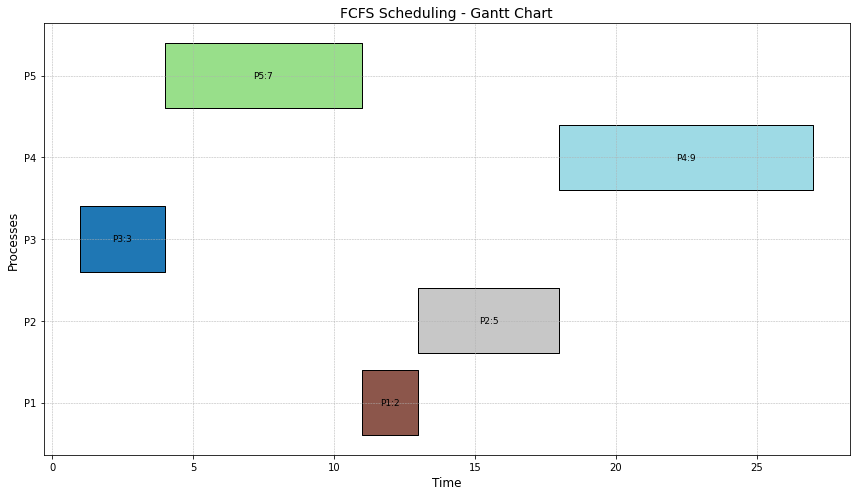

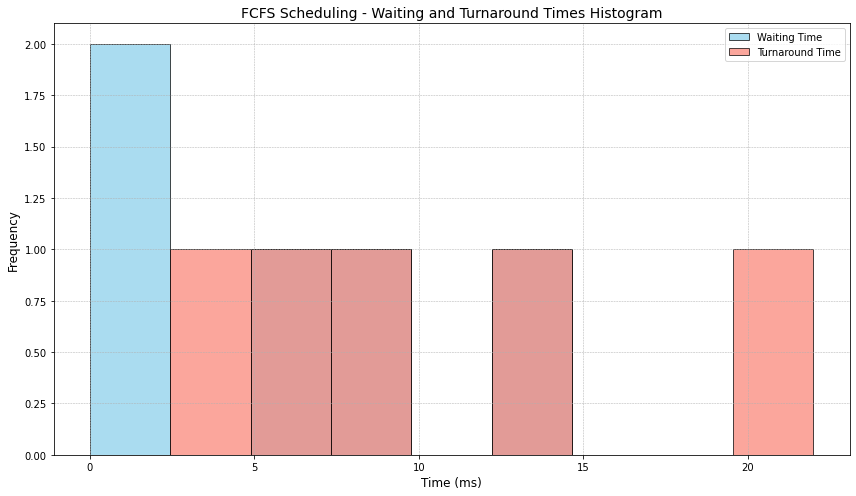

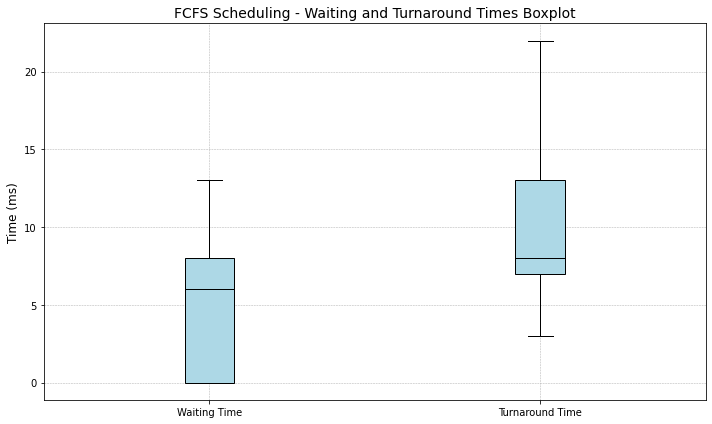

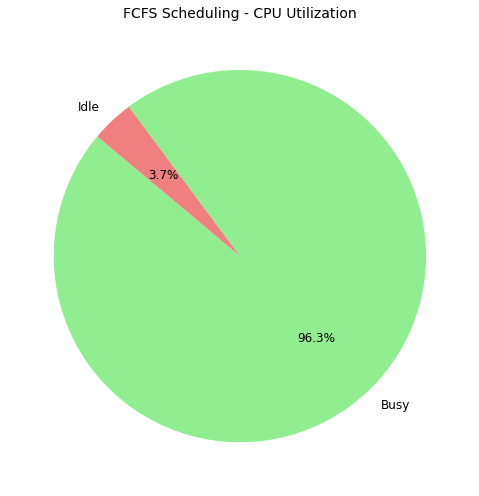

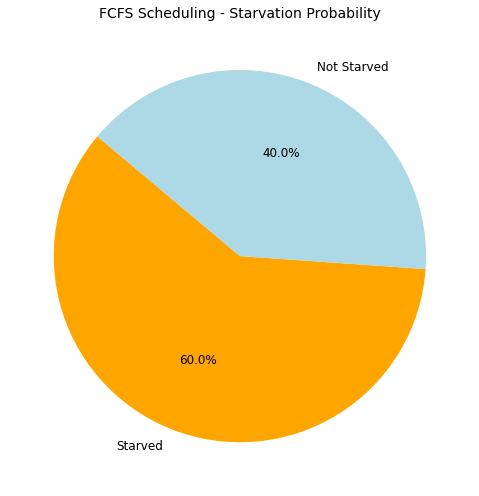


SJF Non-Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      0       |        7        |       11        |
|  1  |      5       |     2      |    1     |      6       |        8        |       13        |
|  2  |      5       |     5      |    2     |      8       |       13        |       18        |
|  4  |      5       |     9      |    1     |      13      |       22        |       27        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


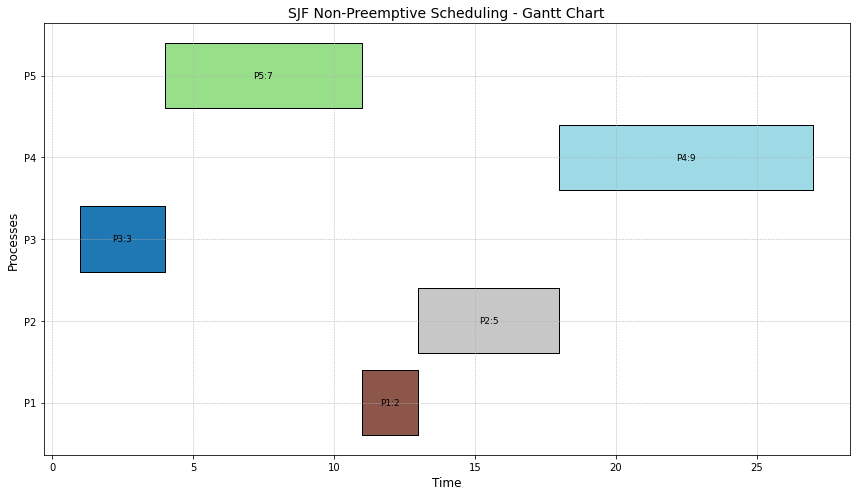

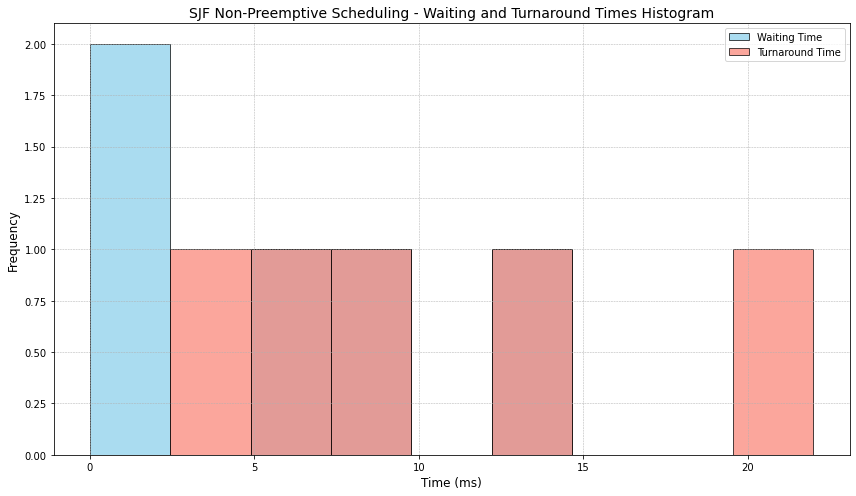

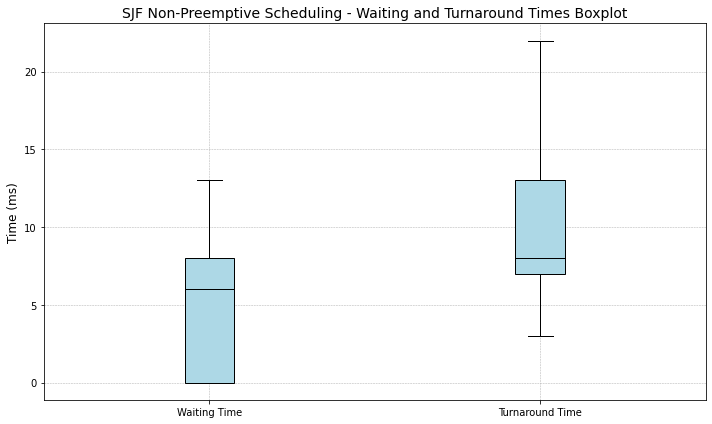

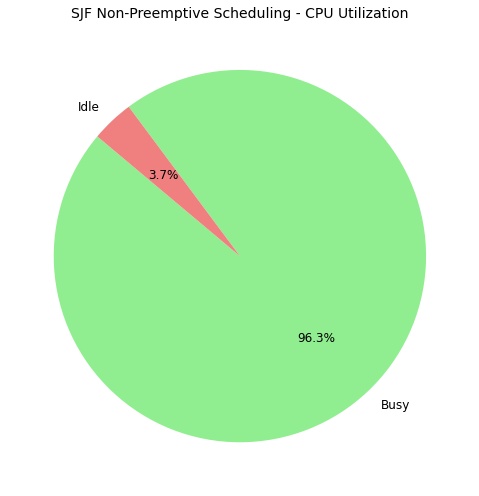

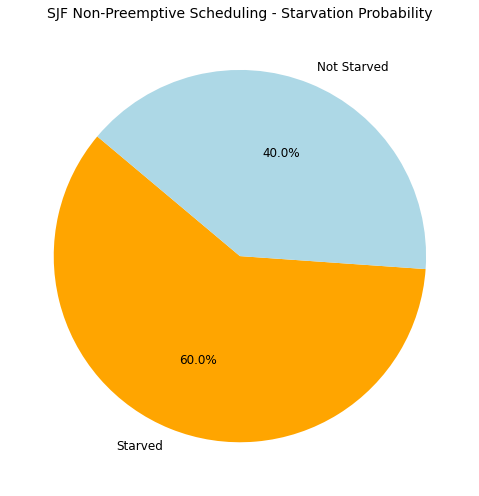


SJF Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      7       |       14        |       18        |
|  1  |      5       |     2      |    1     |      0       |        2        |        7        |
|  2  |      5       |     5      |    2     |      2       |        7        |       12        |
|  4  |      5       |     9      |    1     |      13      |       22        |       27        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


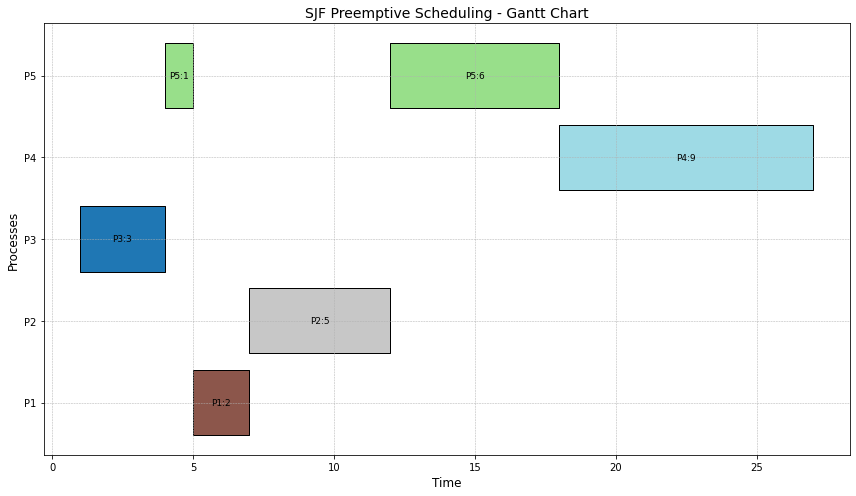

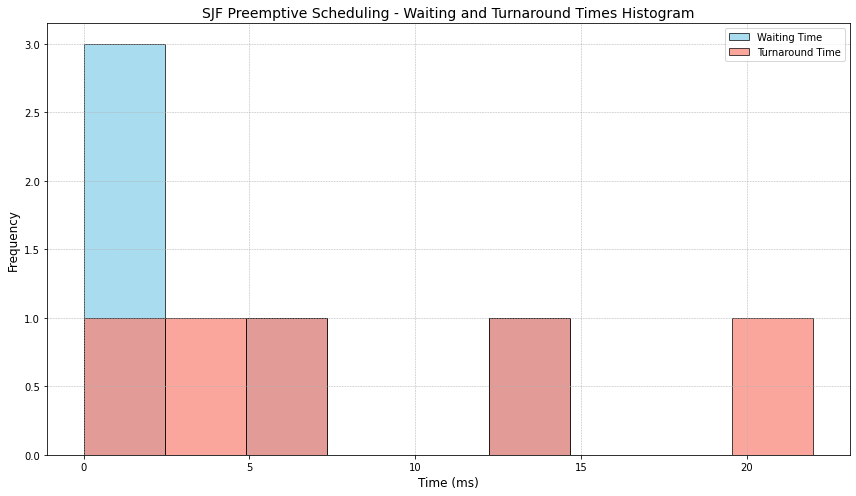

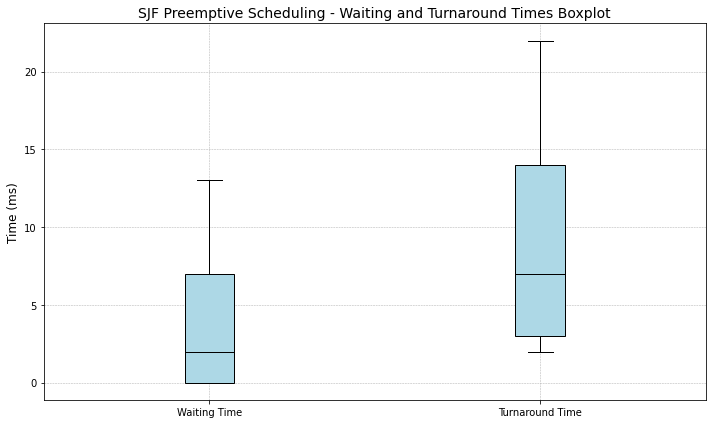

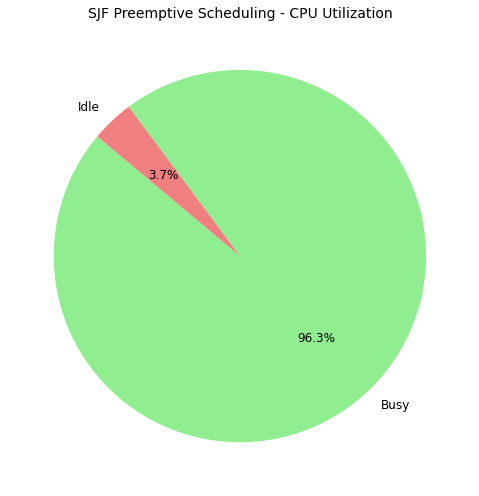

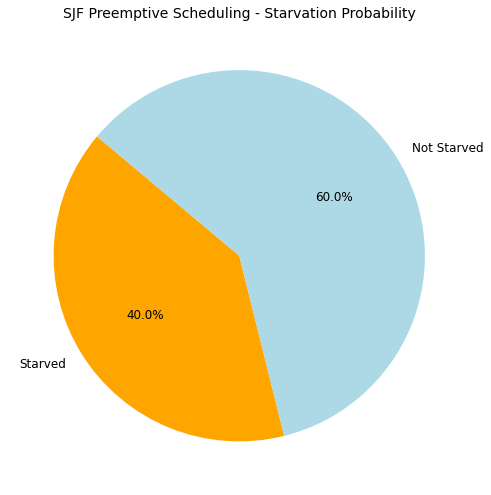


Round Robin Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      10      |       17        |       21        |
|  1  |      5       |     2      |    1     |      3       |        5        |       10        |
|  2  |      5       |     5      |    2     |      12      |       17        |       22        |
|  4  |      5       |     9      |    1     |      13      |       22        |       27        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


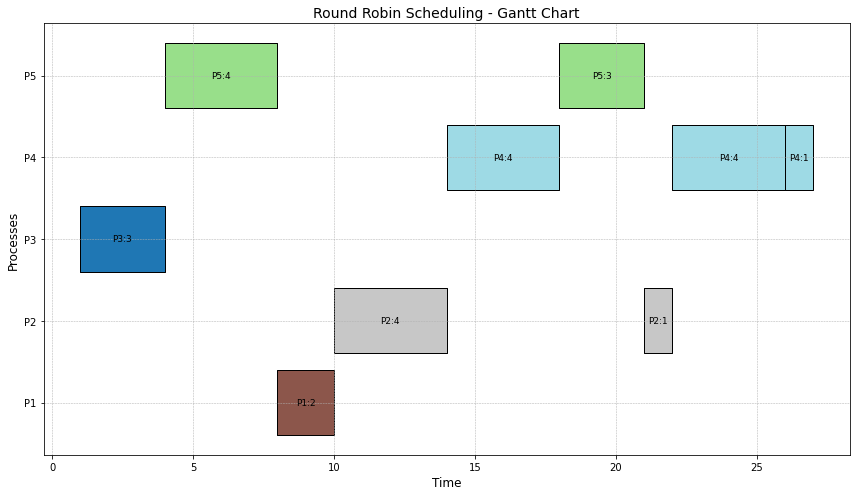

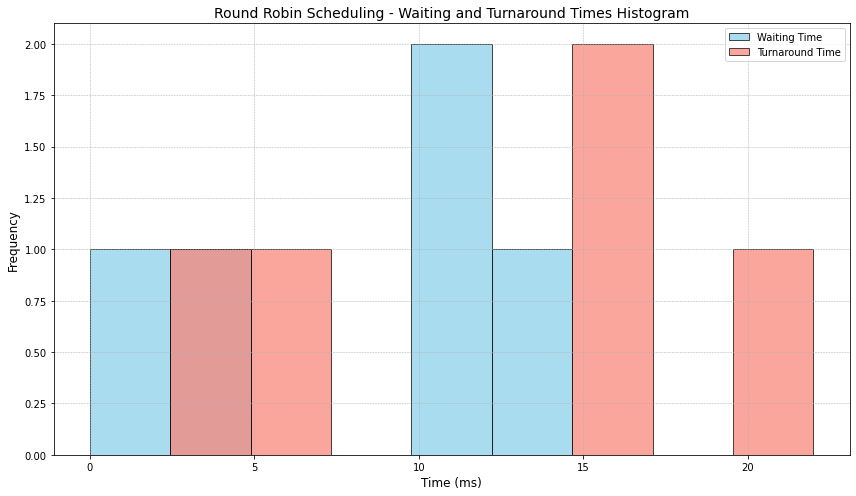

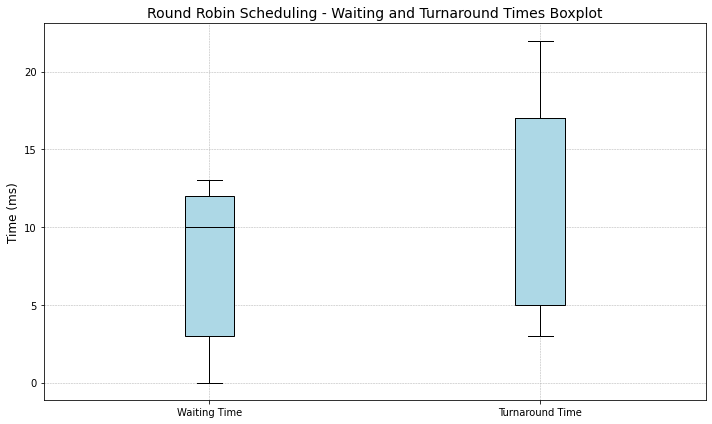

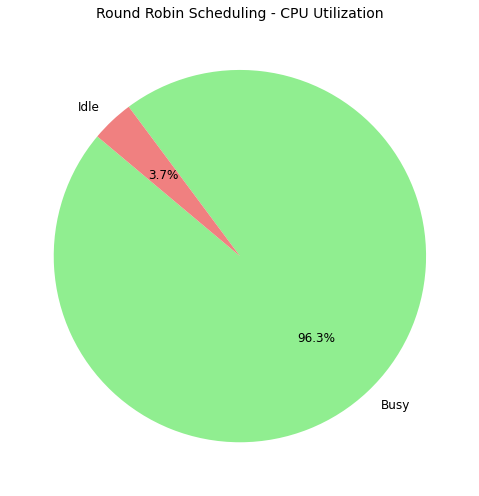

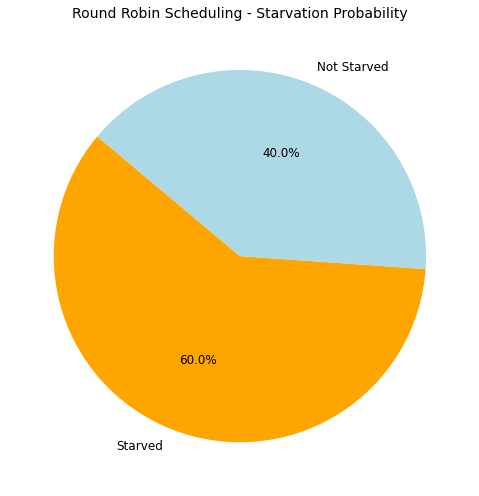


Priority Non-Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      0       |        7        |       11        |
|  1  |      5       |     2      |    1     |      6       |        8        |       13        |
|  2  |      5       |     5      |    2     |      17      |       22        |       27        |
|  4  |      5       |     9      |    1     |      8       |       17        |       22        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


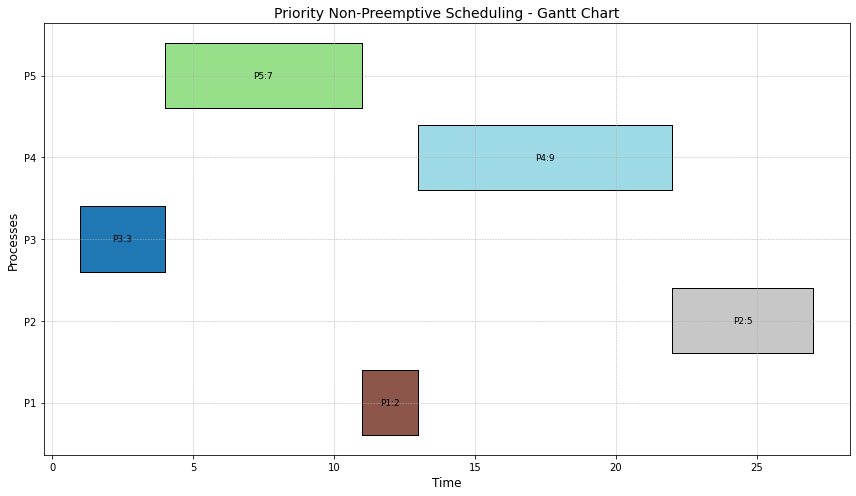

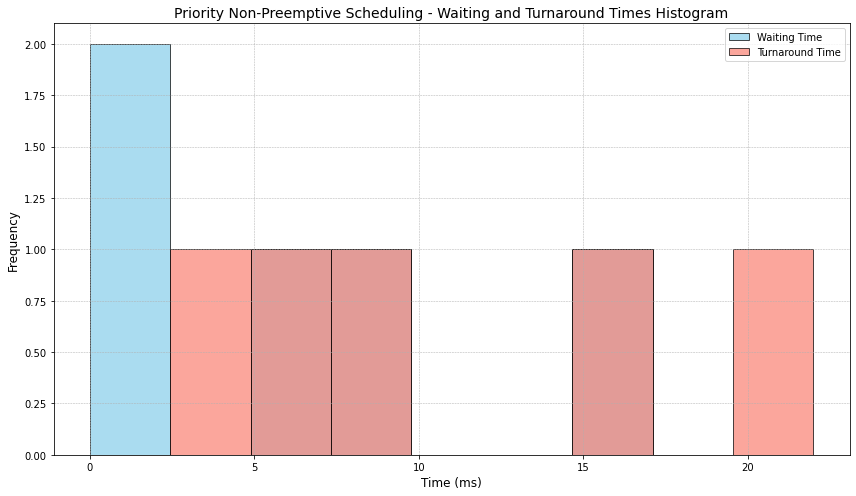

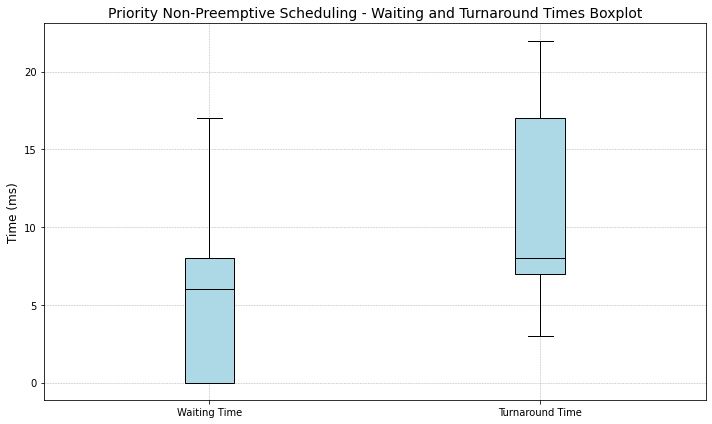

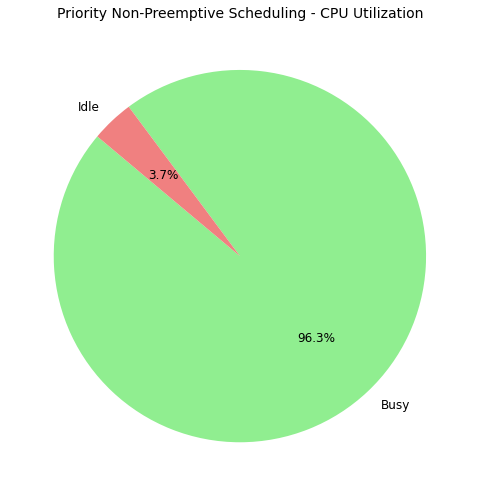

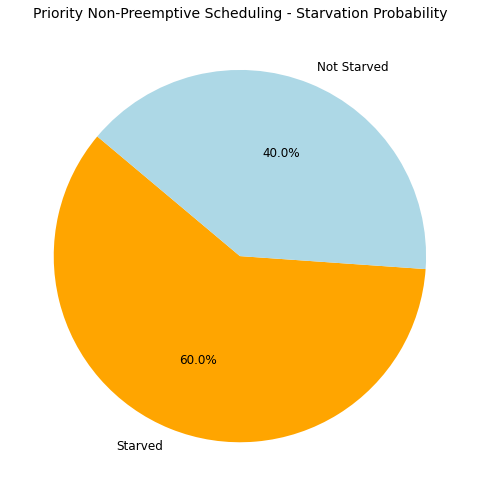


Priority Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  5  |      4       |     7      |    1     |      0       |        7        |       11        |
|  1  |      5       |     2      |    1     |      6       |        8        |       13        |
|  2  |      5       |     5      |    2     |      17      |       22        |       27        |
|  4  |      5       |     9      |    1     |      8       |       17        |       22        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


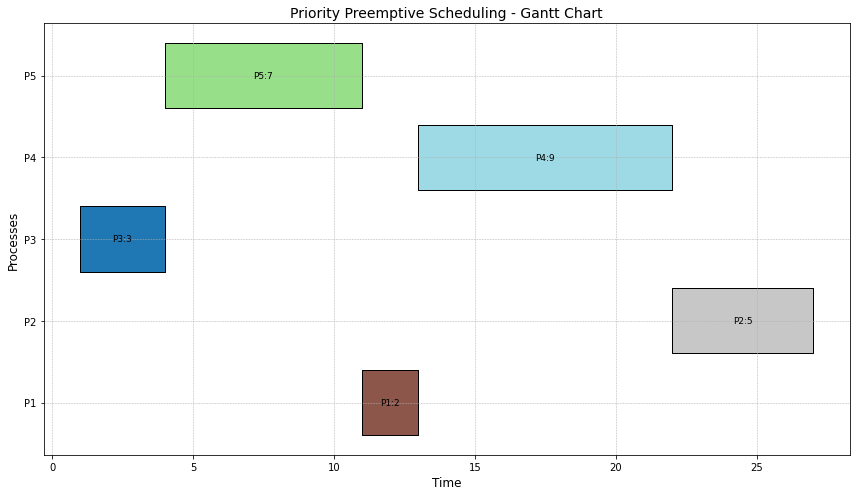

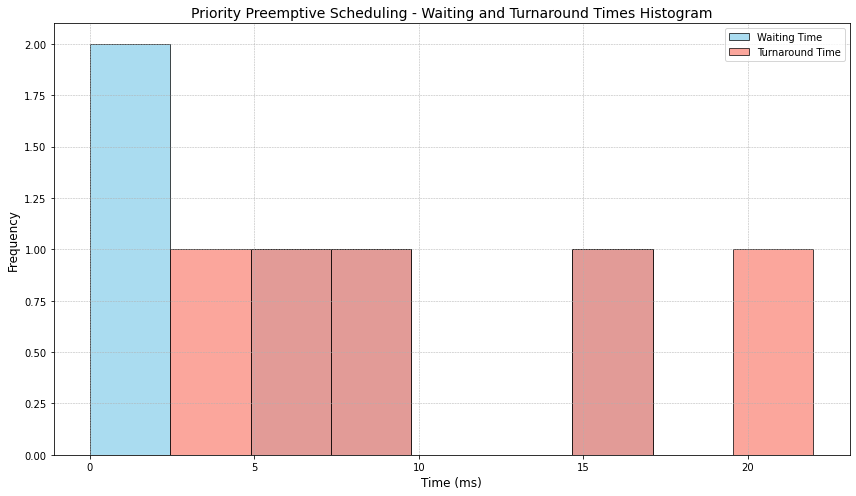

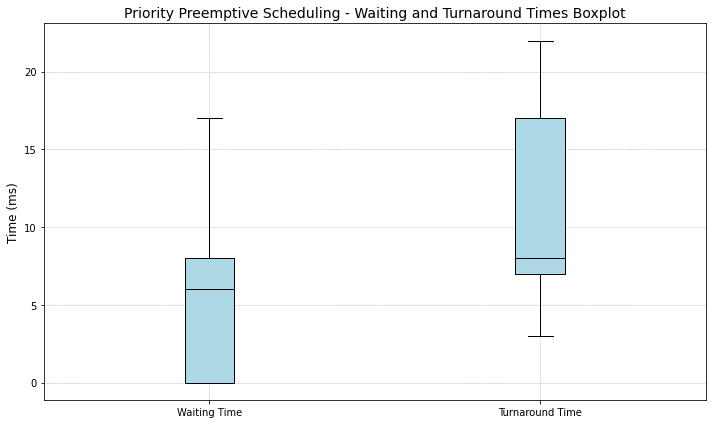

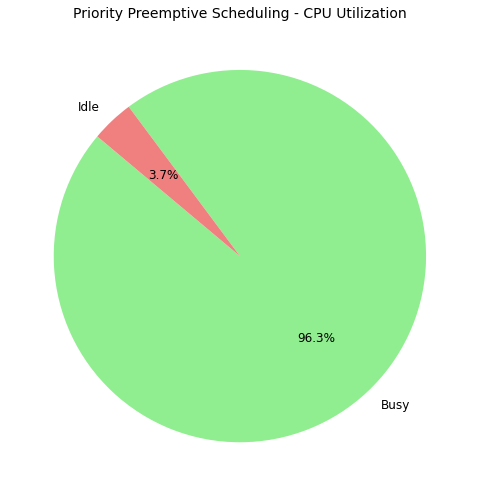

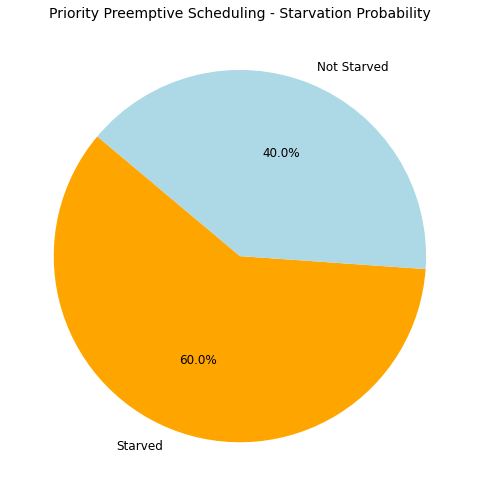


Multilevel Queue Scheduling (Non-preemptive) - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  1  |      5       |     2      |    1     |      6       |        8        |       13        |
|  2  |      5       |     5      |    2     |      8       |       13        |       18        |
|  3  |      1       |     3      |    1     |      0       |        3        |        4        |
|  4  |      5       |     9      |    1     |      13      |       22        |       27        |
|  5  |      4       |     7      |    1     |      0       |        7        |       11        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


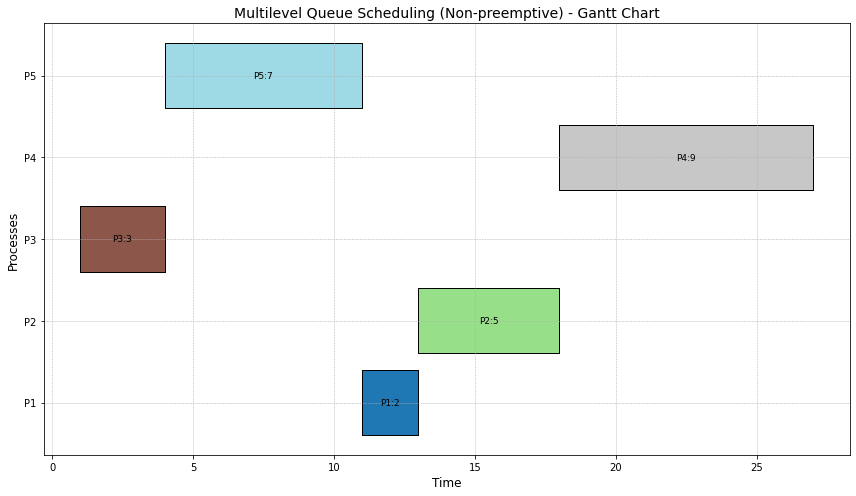

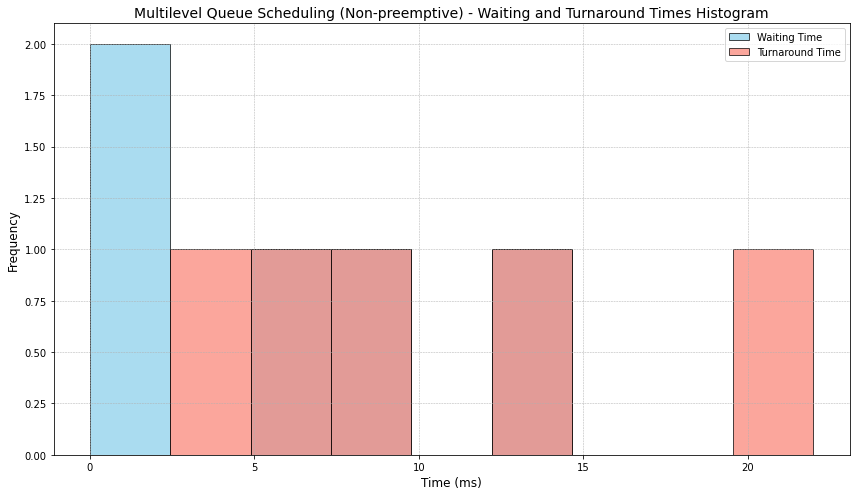

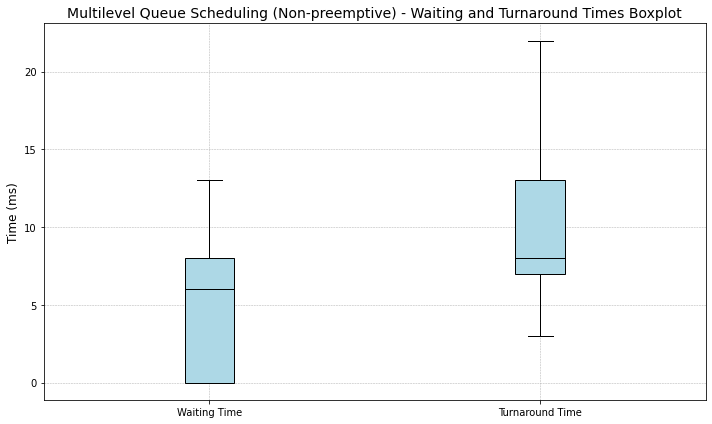

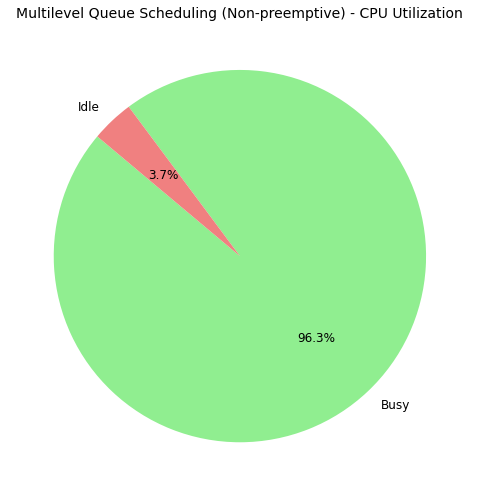

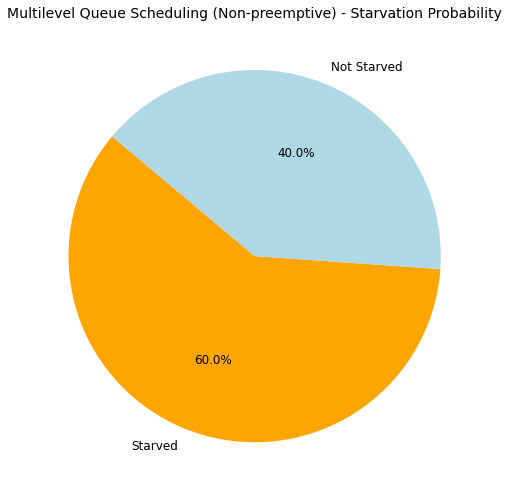


Multilevel Feedback Queue Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  1  |      5       |     2      |    1     |      15      |       17        |       22        |
|  2  |      5       |     5      |    2     |      13      |       18        |       23        |
|  3  |      1       |     3      |    1     |      19      |       22        |       23        |
|  4  |      5       |     9      |    1     |      0       |        0        |        0        |
|  5  |      4       |     7      |    1     |      0       |        0        |        0        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


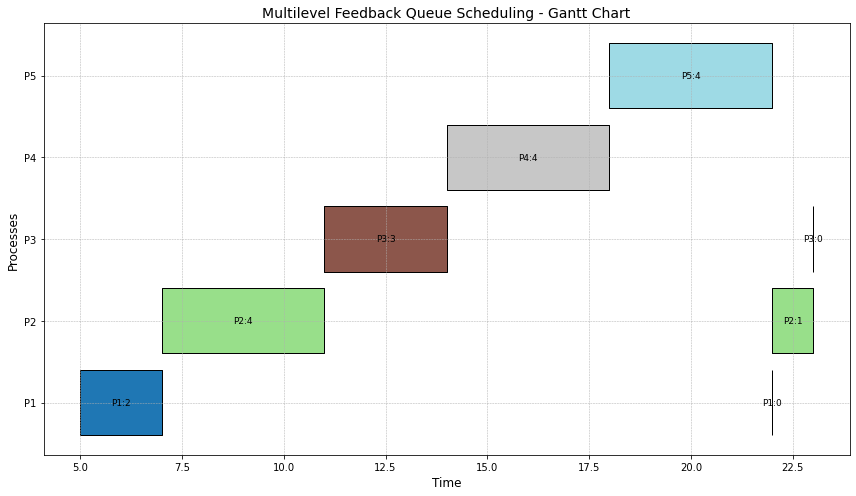

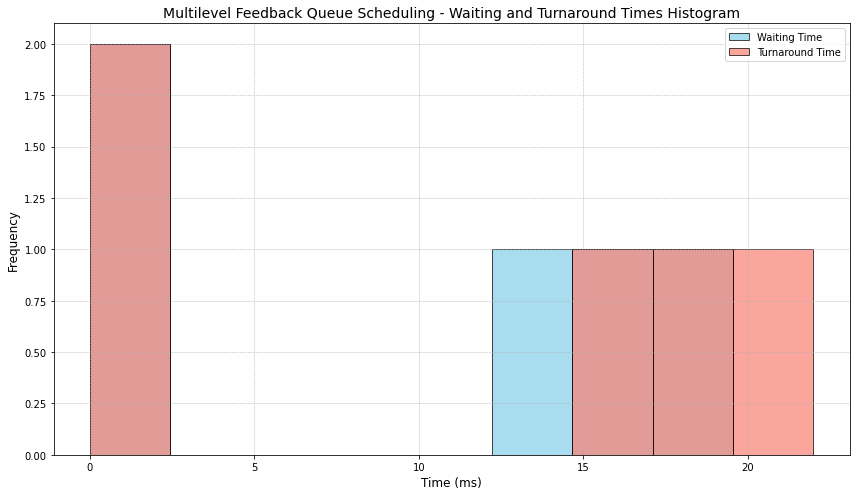

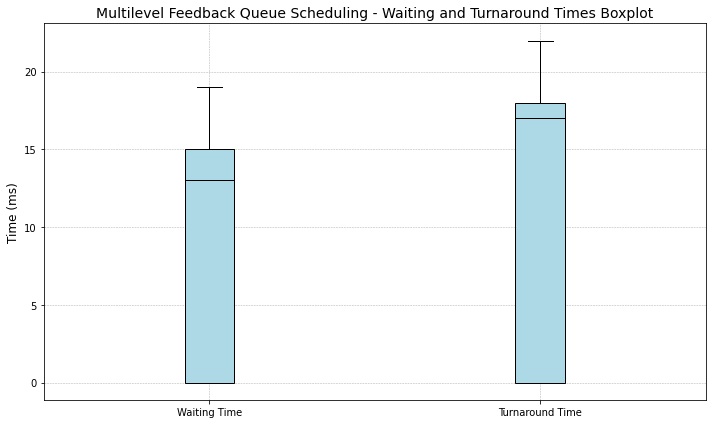

ValueError: Wedge sizes 'x' must be non negative values

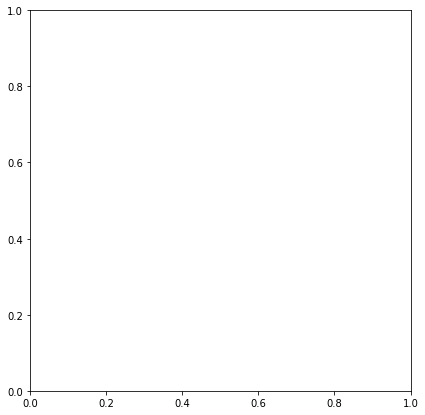

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

# Define Process class with tracking for multiple time slices
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5, queue_level=0):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.queue_level = queue_level  # For multilevel queues
        self.time_slices = []  # List of (start_time, duration) for time slices
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.response_time = None  # For calculating response time in MLFQ
        self.remaining_time = burst_time  # For preemptive algorithms

# FCFS Scheduling (Non-preemptive)
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.time_slices.append((current_time, process.burst_time))
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.completion_time - process.arrival_time
        current_time += process.burst_time

# SJF Scheduling (Non-preemptive)
def sjf_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.completion_time == 0):
                ready_queue.append(process)
        if ready_queue:
            # Select process with shortest burst time
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            process = current_process
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.completion_time - process.arrival_time
            current_time += process.burst_time
            completed += 1
        else:
            # If no process is ready, advance time
            current_time += 1

# SJF Scheduling (Preemptive)
def sjf_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    n = len(processes)
    completed = 0
    ready_queue = []
    last_process = None
    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.remaining_time > 0):
                ready_queue.append(process)
        if ready_queue:
            # Select process with shortest remaining time
            ready_queue.sort(key=lambda x: x.remaining_time)
            current_process = ready_queue[0]
            if last_process != current_process:
                current_process.time_slices.append((current_time, 1))
            else:
                # Extend the last time slice
                start_time, duration = current_process.time_slices.pop()
                current_process.time_slices.append((start_time, duration + 1))
            current_time += 1
            current_process.remaining_time -= 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                ready_queue.remove(current_process)
                completed += 1
            last_process = current_process
        else:
            current_time += 1
            last_process = None

# Round Robin Scheduling (Preemptive)
def round_robin_scheduling(processes, time_quantum=4):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    queue = []
    n = len(processes)
    completed = 0
    idx = 0  # Index to track processes that have arrived
    while completed < n:
        # Add processes that have arrived to the queue
        while idx < n and processes[idx].arrival_time <= current_time:
            queue.append(processes[idx])
            idx += 1
        if queue:
            process = queue.pop(0)
            if process.remaining_time > 0:
                if current_time < process.arrival_time:
                    current_time = process.arrival_time
                time_slice = min(time_quantum, process.remaining_time)
                process.time_slices.append((current_time, time_slice))
                current_time += time_slice
                process.remaining_time -= time_slice
                if process.remaining_time > 0:
                    # Check for newly arrived processes before re-adding current process
                    while idx < n and processes[idx].arrival_time <= current_time:
                        queue.append(processes[idx])
                        idx += 1
                    queue.append(process)
                else:
                    process.completion_time = current_time
                    process.turnaround_time = process.completion_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed += 1
        else:
            # If no processes are ready, advance time to the next arrival
            if idx < n:
                current_time = processes[idx].arrival_time
            else:
                break

# Priority Scheduling (Non-preemptive)
def priority_non_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    n = len(processes)
    completed = 0
    ready_queue = []
    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.completion_time == 0):
                ready_queue.append(process)
        if ready_queue:
            # Select process with highest priority (lowest priority number)
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            process = current_process
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.completion_time - process.arrival_time
            current_time += process.burst_time
            completed += 1
        else:
            # If no process is ready, advance time
            current_time += 1

# Priority Scheduling (Preemptive)
def priority_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    n = len(processes)
    completed = 0
    ready_queue = []
    last_process = None
    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if (process.arrival_time <= current_time and
                process.remaining_time > 0 and
                process not in ready_queue):
                ready_queue.append(process)
        if ready_queue:
            # Select process with highest priority (lowest priority number)
            ready_queue.sort(key=lambda x: (x.priority, x.arrival_time))
            current_process = ready_queue[0]
            if last_process != current_process:
                current_process.time_slices.append((current_time, 1))
            else:
                # Extend the last time slice
                start_time, duration = current_process.time_slices.pop()
                current_process.time_slices.append((start_time, duration + 1))
            current_time += 1
            current_process.remaining_time -= 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                ready_queue.remove(current_process)
                completed += 1
            last_process = current_process
        else:
            current_time += 1
            last_process = None

# Multilevel Queue Scheduling (Non-preemptive)
def multilevel_queue_scheduling(processes):
    # Define queues based on priority
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    current_time = 0
    queues = [high_priority, low_priority]
    for queue in queues:
        # Use FCFS scheduling within each queue
        queue.sort(key=lambda x: x.arrival_time)
        for process in queue:
            if current_time < process.arrival_time:
                current_time = process.arrival_time
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.completion_time - process.arrival_time
            current_time += process.burst_time

# Multilevel Feedback Queue Scheduling
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_levels=3):
    queues = [[] for _ in range(num_levels)]
    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)
    current_time = 0
    n = len(processes)
    completed = 0
    idx = 0
    while completed < n:
        # Add arriving processes to the highest priority queue
        while idx < n and processes[idx].arrival_time <= current_time:
            queues[0].append(processes[idx])
            idx += 1
        executed = False
        for i in range(num_levels):
            queue = queues[i]
            if queue:
                process = queue.pop(0)
                if current_time < process.arrival_time:
                    current_time = process.arrival_time
                quantum = time_quantum * (2 ** i)
                time_slice = min(quantum, process.remaining_time)
                process.time_slices.append((current_time, time_slice))
                current_time += time_slice
                process.remaining_time -= time_slice
                if process.remaining_time > 0:
                    if i + 1 < num_levels:
                        queues[i + 1].append(process)
                    else:
                        queues[i].append(process)
                else:
                    process.completion_time = current_time
                    process.turnaround_time = current_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed += 1
                executed = True
                break
        if not executed:
            current_time += 1

# Visualization Functions
def gantt_chart(processes, title="Gantt Chart"):
    fig, ax = plt.subplots(figsize=(12, 7))
    cmap = plt.get_cmap('tab20')
    num_processes = len(processes)
    colors = [cmap(i) for i in np.linspace(0, 1, num_processes)]
    for idx, p in enumerate(processes):
        color = colors[idx % len(colors)]
        for (start_time, duration) in p.time_slices:
            ax.broken_barh([(start_time, duration)], (p.pid - 0.4, 0.8),
                           facecolors=(color), edgecolors='black', linewidth=1)
            label = f'P{p.pid}:{duration}'
            ax.text(start_time + duration / 2, p.pid, label, ha='center', va='center',
                    color='black', fontsize=9)
    ax.set_yticks([p.pid for p in processes])
    ax.set_yticklabels([f'P{p.pid}' for p in processes], fontsize=10)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Processes', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def waiting_turnaround_histogram(waiting_times, turnaround_times, title="Waiting and Turnaround Times Histogram"):
    plt.figure(figsize=(12, 7))
    bins = np.linspace(0, max(max(waiting_times), max(turnaround_times)), 10)
    plt.hist(waiting_times, bins=bins, alpha=0.7, label="Waiting Time", color='skyblue', edgecolor='black')
    plt.hist(turnaround_times, bins=bins, alpha=0.7, label="Turnaround Time", color='salmon', edgecolor='black')
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def waiting_turnaround_boxplot(waiting_times, turnaround_times, title="Boxplot of Waiting and Turnaround Times"):
    data = [waiting_times, turnaround_times]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=["Waiting Time", "Turnaround Time"], patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='black'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='black'),
                 capprops=dict(color='black'))
    plt.title(title, fontsize=14)
    plt.ylabel("Time (ms)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def cpu_utilization(processes, total_time, title="CPU Utilization"):
    busy_time = sum(p.burst_time for p in processes)
    if total_time == 0:  # Prevent division by zero
        print(f"Warning: {title} - Total time is zero, unable to calculate CPU Utilization.")
        return
    utilization = (busy_time / total_time) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([utilization, 100 - utilization],
            labels=["Busy", "Idle"],
            autopct='%1.1f%%',
            startangle=140,
            colors=['lightgreen', 'lightcoral'],
            textprops={'fontsize': 12})
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def starvation_probability(processes, threshold=5, title="Starvation Probability"):
    starved = [1 if p.waiting_time > threshold else 0 for p in processes]
    probability = sum(starved) / len(processes) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([probability, 100 - probability],
            labels=["Starved", "Not Starved"],
            autopct='%1.1f%%',
            startangle=140,
            colors=['orange', 'lightblue'],
            textprops={'fontsize':12})
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Main Execution Function for Visualization and Data Display
def visualize_all(processes, scheduling_function, title="Scheduling Algorithm Analysis", **kwargs):
    # Run the scheduling algorithm
    scheduling_function(processes, **kwargs)
    waiting_times = [p.waiting_time for p in processes]
    turnaround_times = [p.turnaround_time for p in processes]
    total_time = max([p.completion_time for p in processes]) if processes else 0

    # Create Table of Process Information
    process_info = []
    for p in processes:
        process_info.append([
            p.pid,
            p.arrival_time,
            p.burst_time,
            p.priority,
            p.waiting_time,
            p.turnaround_time,
            p.completion_time
        ])
    headers = ["PID", "Arrival Time", "Burst Time", "Priority", "Waiting Time", "Turnaround Time", "Completion Time"]
    print(f"\n{title} - Process Information:\n")
    print(tabulate(process_info, headers=headers, tablefmt='pretty'))

    # Gantt Chart
    gantt_chart(processes, title=f"{title} - Gantt Chart")

    # Histogram of Waiting and Turnaround Times
    waiting_turnaround_histogram(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Histogram")

    # Boxplot of Waiting and Turnaround Times
    waiting_turnaround_boxplot(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Boxplot")

    # CPU Utilization
    cpu_utilization(processes, total_time, title=f"{title} - CPU Utilization")

    # Starvation Probability
    starvation_probability(processes, title=f"{title} - Starvation Probability")

# Example usage with different scheduling algorithms
if __name__ == "__main__":
    # Generate random processes for testing
    random.seed(42)  # Set seed for reproducibility
    processes = [Process(pid=i+1,
                         arrival_time=random.randint(0, 5),
                         burst_time=random.randint(1, 10),
                         priority=random.randint(1, 5)) for i in range(5)]

    # Make a deep copy of the processes for each scheduling algorithm
    import copy
    algorithms = [
        ("FCFS Scheduling", fcfs_scheduling, {}),
        ("SJF Non-Preemptive Scheduling", sjf_scheduling, {}),
        ("SJF Preemptive Scheduling", sjf_preemptive_scheduling, {}),
        ("Round Robin Scheduling", round_robin_scheduling, {"time_quantum": 4}),
        ("Priority Non-Preemptive Scheduling", priority_non_preemptive_scheduling, {}),
        ("Priority Preemptive Scheduling", priority_preemptive_scheduling, {}),
        ("Multilevel Queue Scheduling (Non-preemptive)", multilevel_queue_scheduling, {}),
        ("Multilevel Feedback Queue Scheduling", multilevel_feedback_queue_scheduling, {"time_quantum": 4, "num_levels": 3})
    ]

    for title, func, params in algorithms:
        # Use deep copy to ensure each algorithm gets the original processes
        proc_copy = copy.deepcopy(processes)
        visualize_all(proc_copy, func, title=title, **params)



FCFS Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      0       |       10        |       11        |
|  3  |      2       |     2      |    5     |      9       |       11        |       13        |
|  2  |      4       |     4      |    2     |      9       |       13        |       17        |
|  1  |      10      |     2      |    1     |      7       |        9        |       19        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


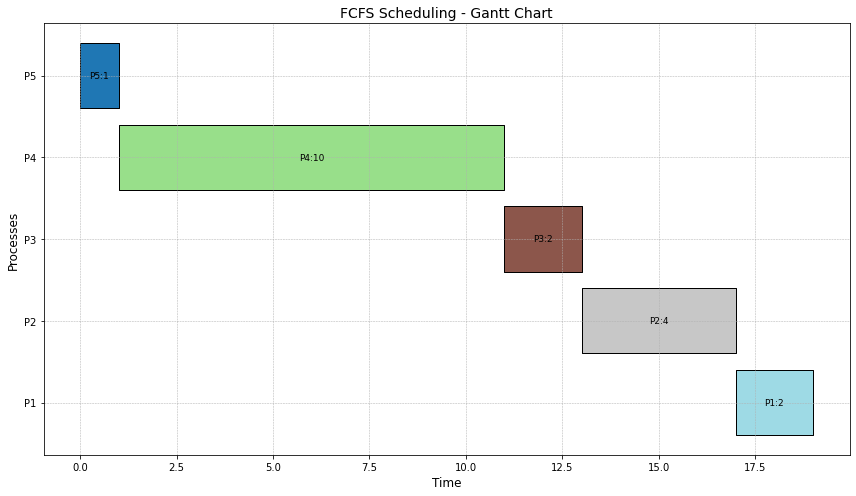

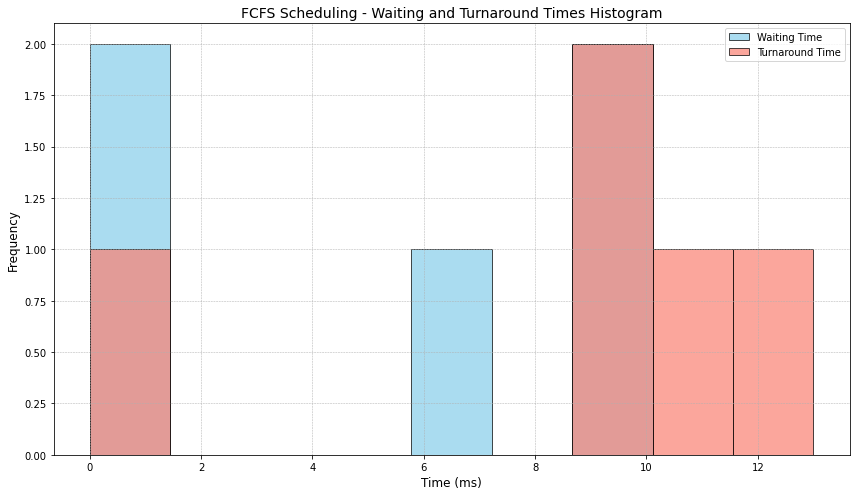

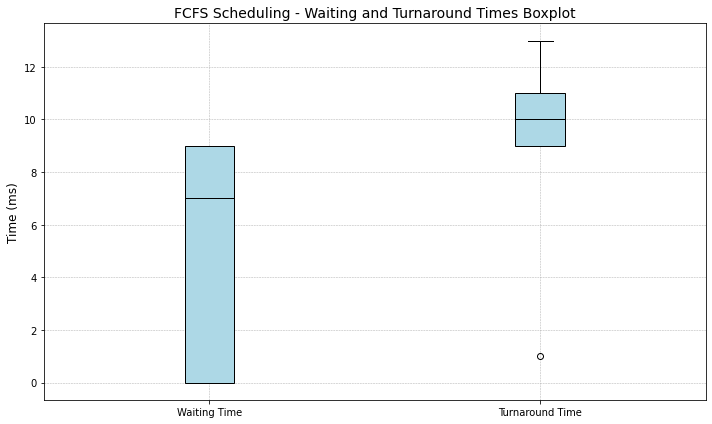

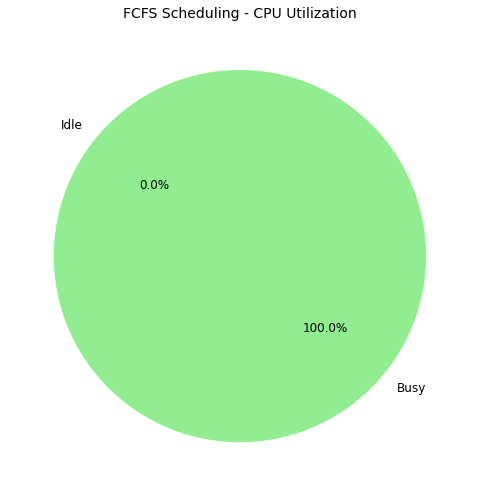

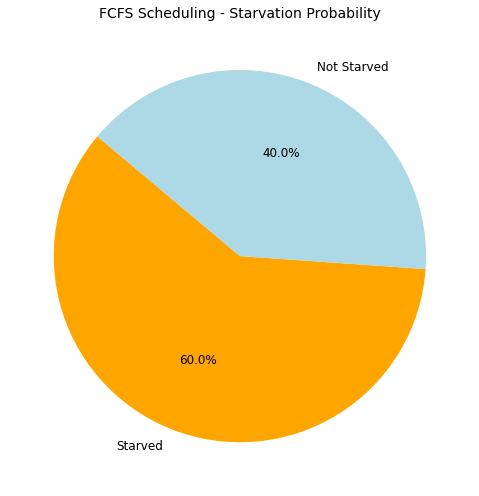


SJF Non-Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      0       |       10        |       11        |
|  3  |      2       |     2      |    5     |      9       |       11        |       13        |
|  2  |      4       |     4      |    2     |      11      |       15        |       19        |
|  1  |      10      |     2      |    1     |      3       |        5        |       15        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


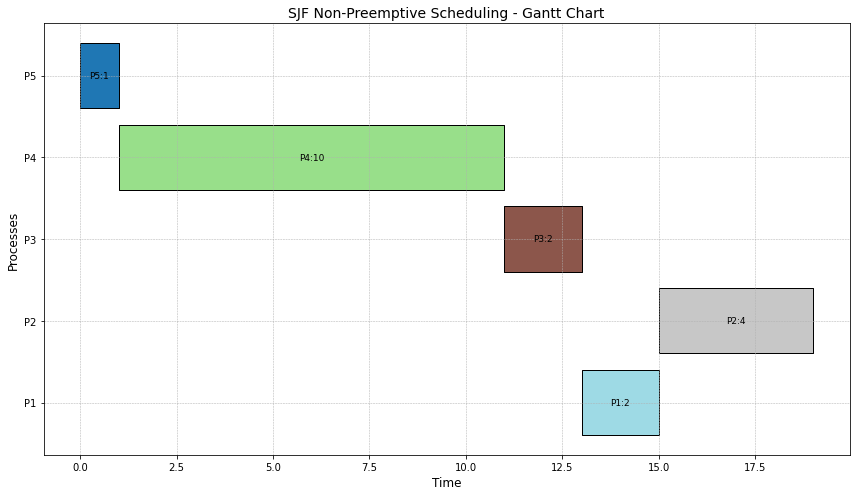

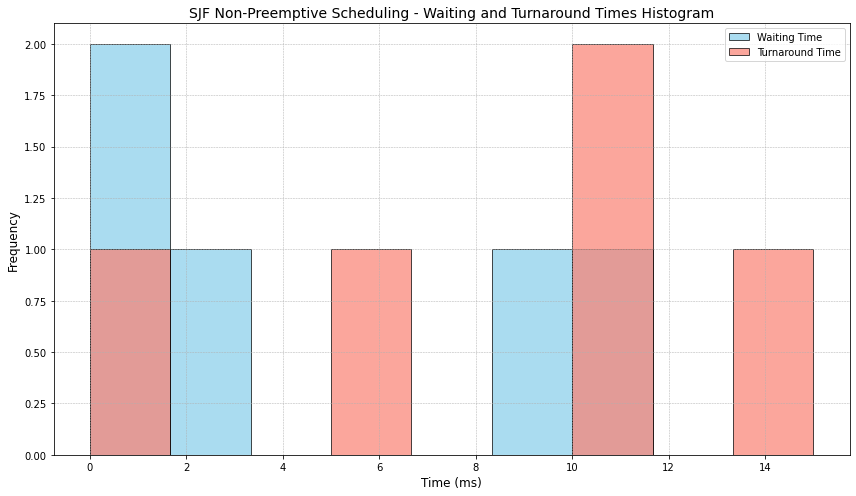

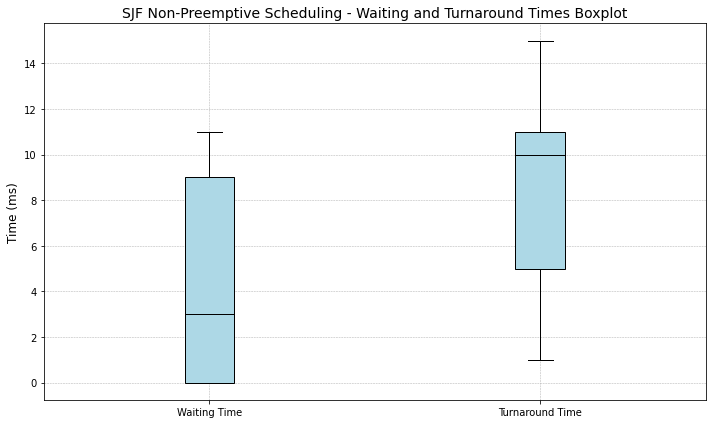

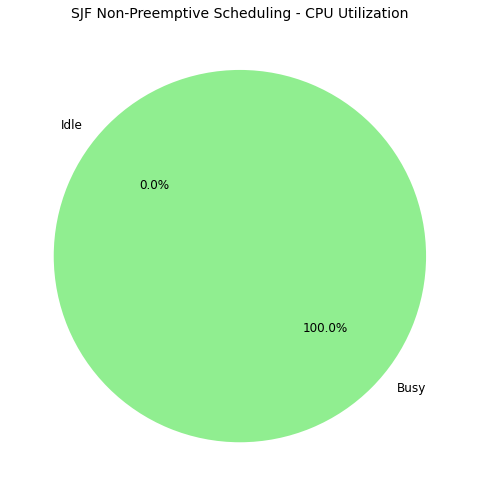

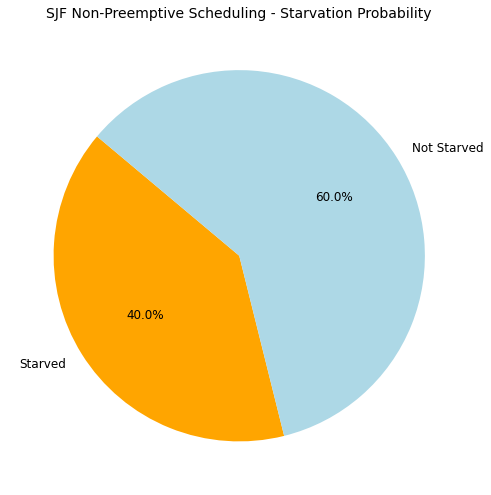


SJF Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      8       |       18        |       19        |
|  3  |      2       |     2      |    5     |      0       |        2        |        4        |
|  2  |      4       |     4      |    2     |      0       |        4        |        8        |
|  1  |      10      |     2      |    1     |      0       |        2        |       12        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


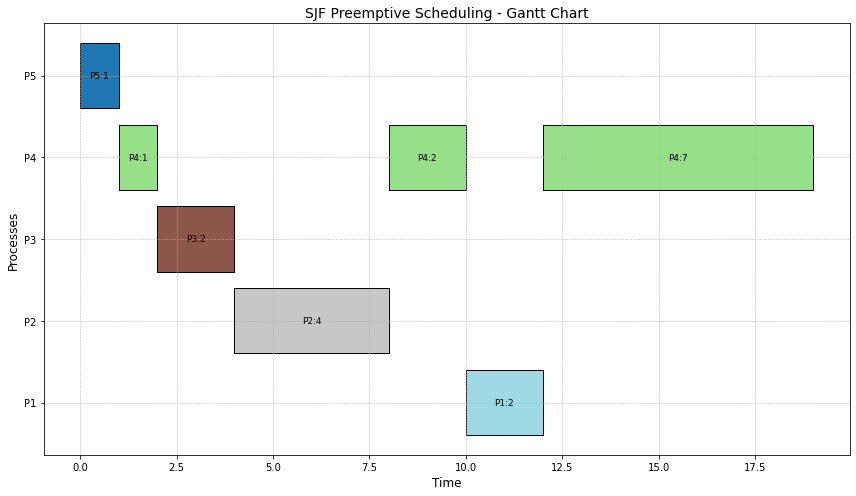

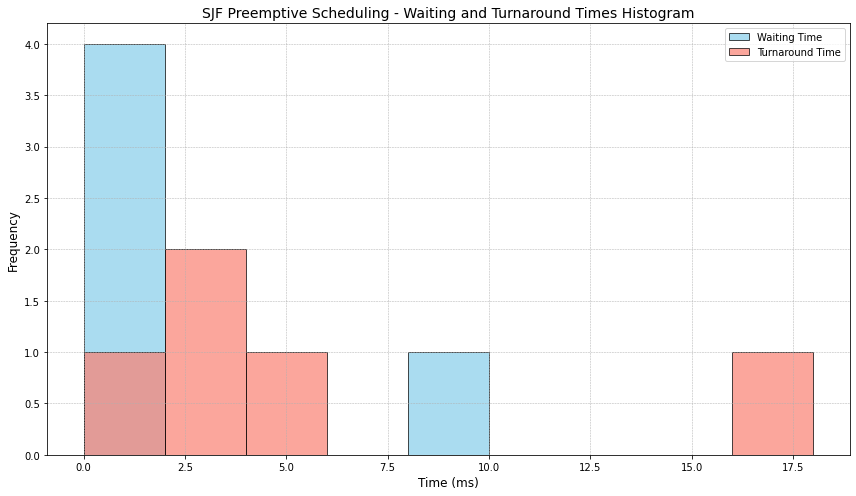

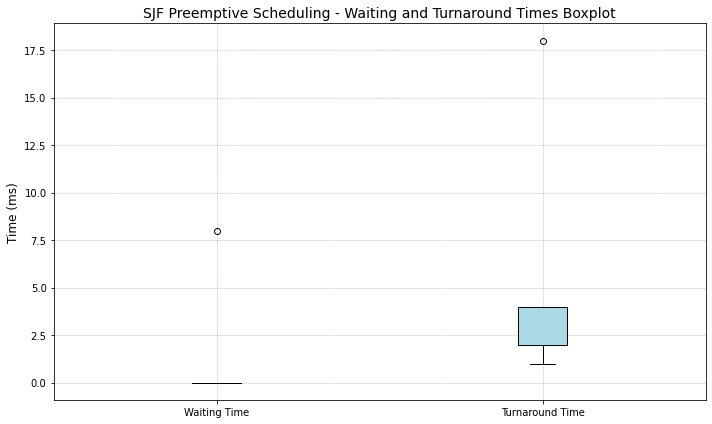

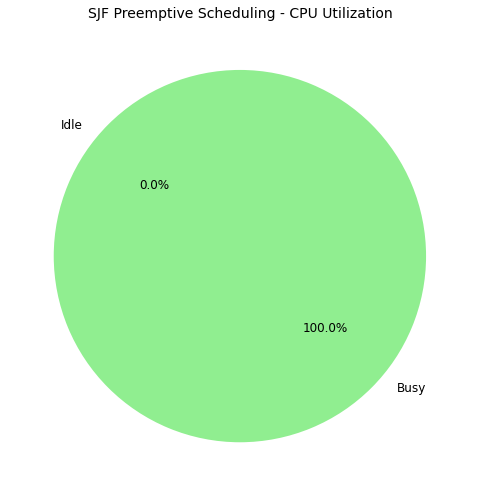

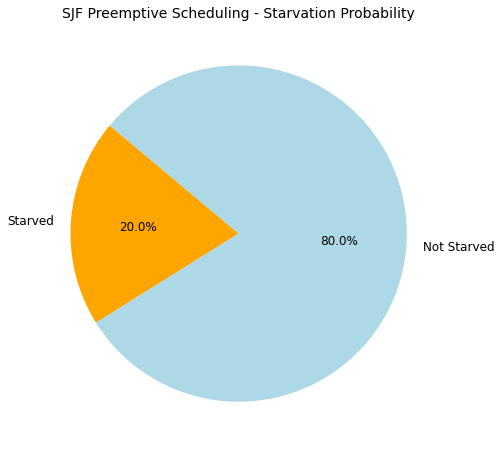


Round Robin Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      8       |       18        |       19        |
|  3  |      2       |     2      |    5     |      3       |        5        |        7        |
|  2  |      4       |     4      |    2     |      3       |        7        |       11        |
|  1  |      10      |     2      |    1     |      5       |        7        |       17        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


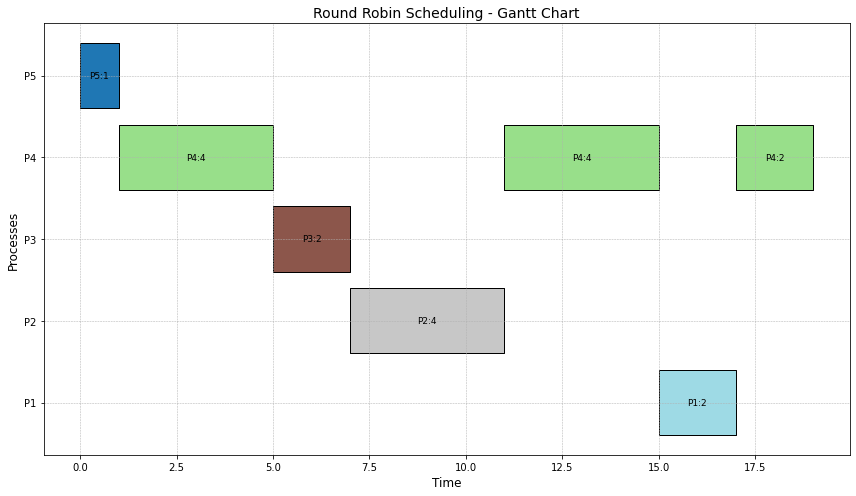

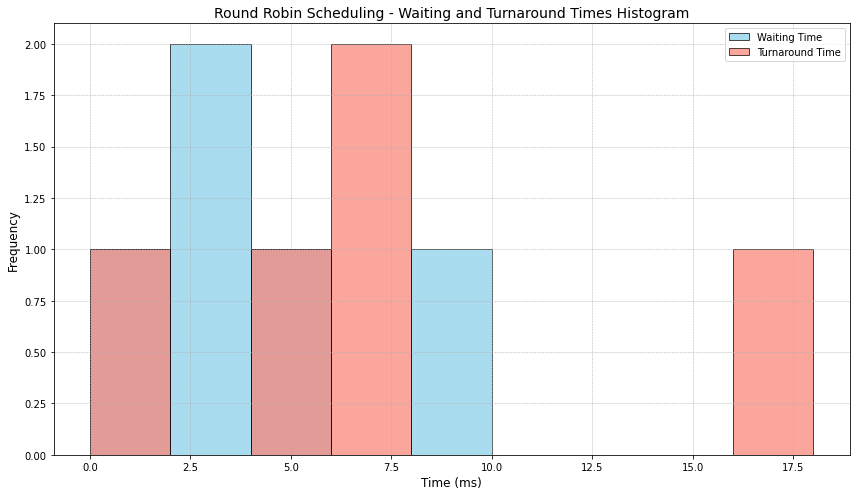

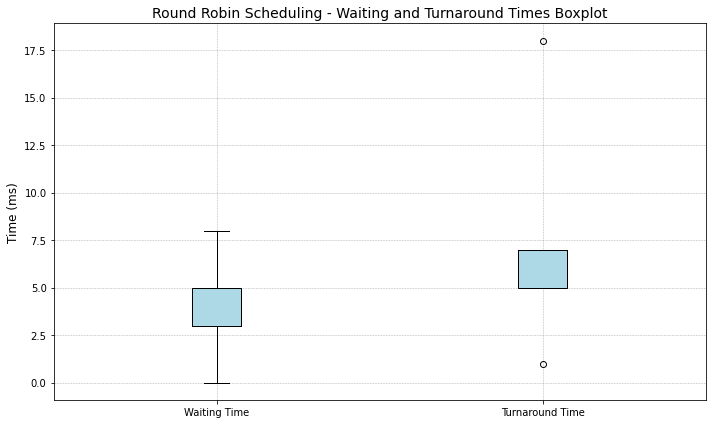

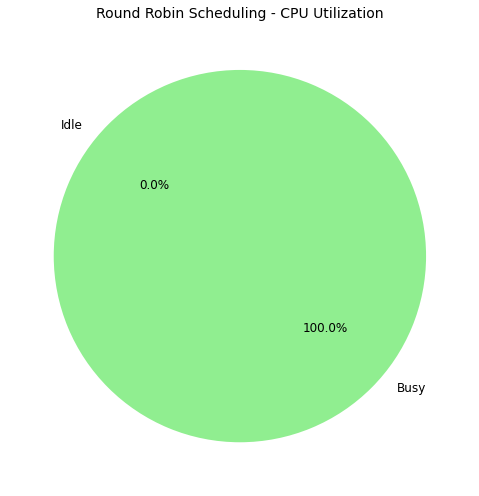

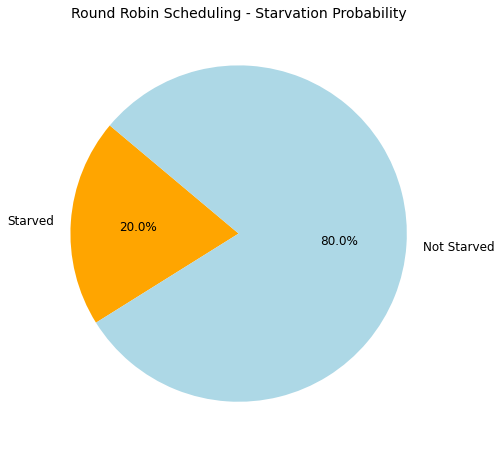


Priority Non-Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      0       |       10        |       11        |
|  3  |      2       |     2      |    5     |      15      |       17        |       19        |
|  2  |      4       |     4      |    2     |      9       |       13        |       17        |
|  1  |      10      |     2      |    1     |      1       |        3        |       13        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


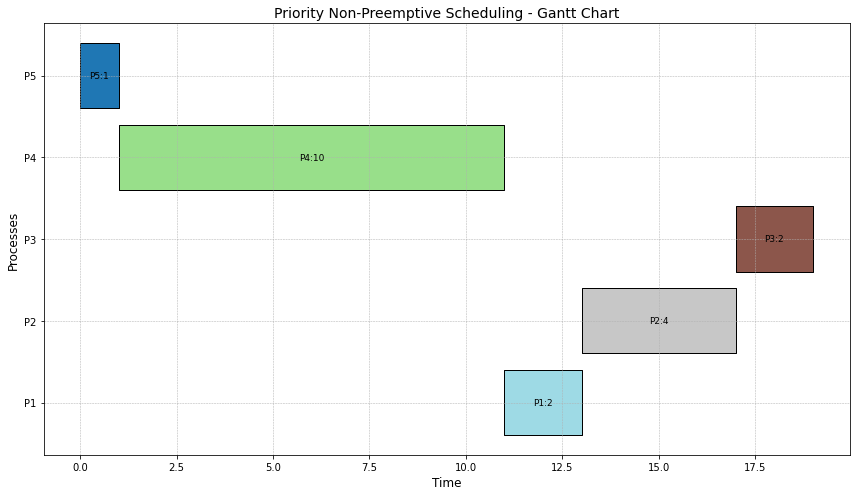

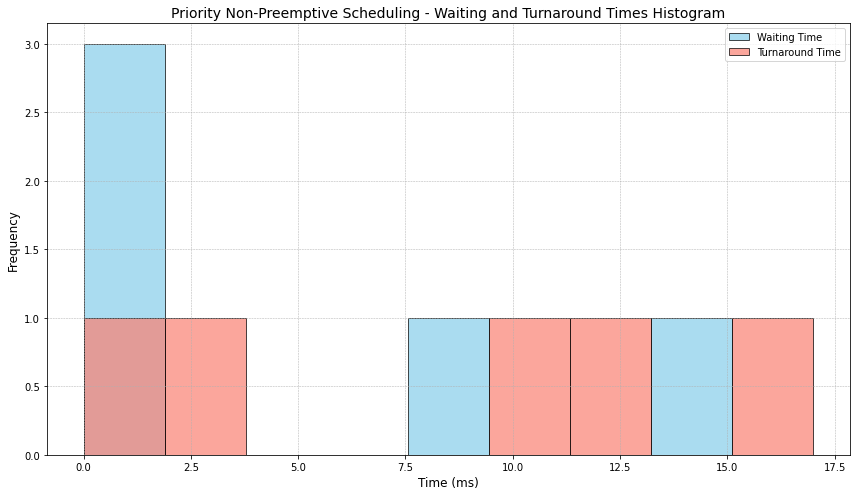

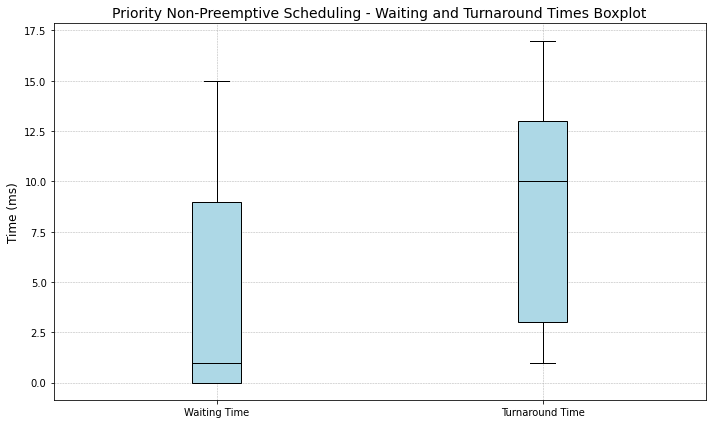

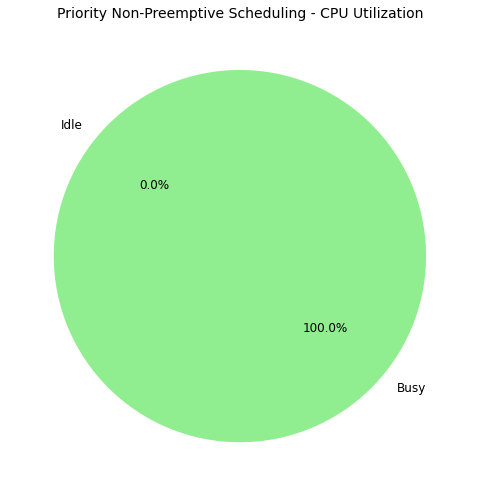

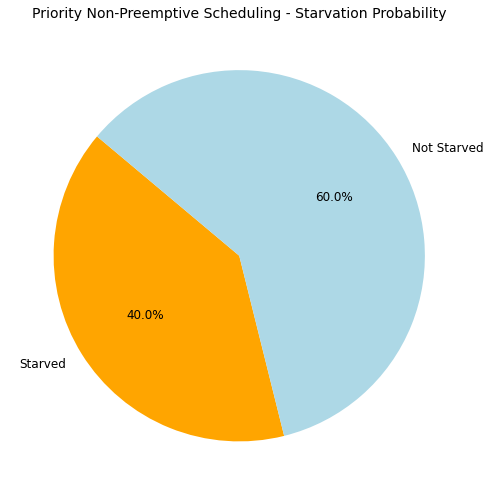


Priority Preemptive Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
|  4  |      1       |     10     |    4     |      6       |       16        |       17        |
|  3  |      2       |     2      |    5     |      15      |       17        |       19        |
|  2  |      4       |     4      |    2     |      0       |        4        |        8        |
|  1  |      10      |     2      |    1     |      0       |        2        |       12        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


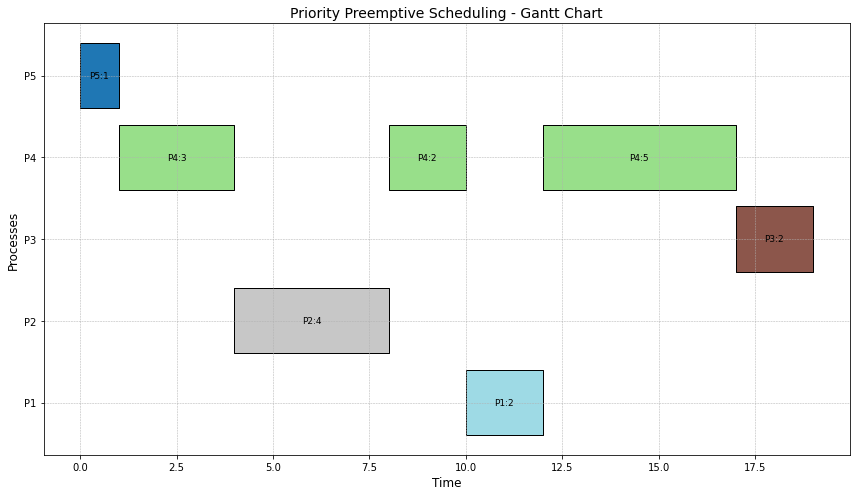

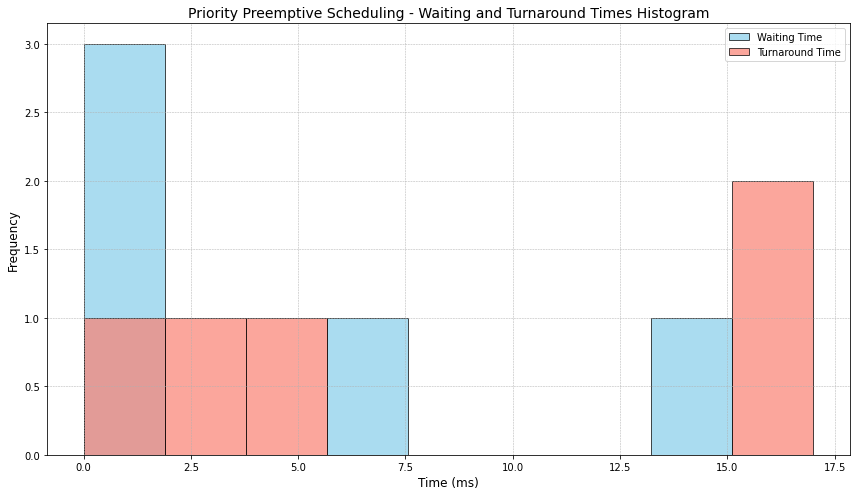

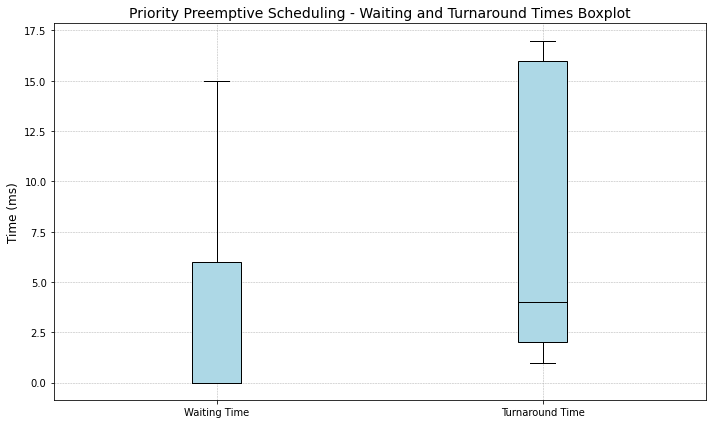

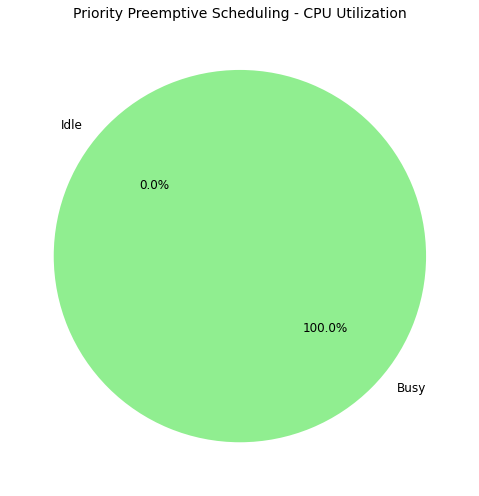

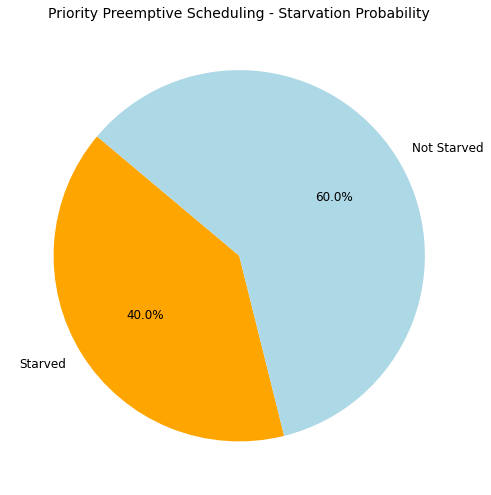


Multilevel Queue Scheduling (Non-Preemptive) - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  1  |      10      |     2      |    1     |      0       |        2        |       12        |
|  2  |      4       |     4      |    2     |      0       |        4        |        8        |
|  3  |      2       |     2      |    5     |      20      |       22        |       24        |
|  4  |      1       |     10     |    4     |      11      |       21        |       22        |
|  5  |      0       |     1      |    1     |      0       |        1        |        1        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


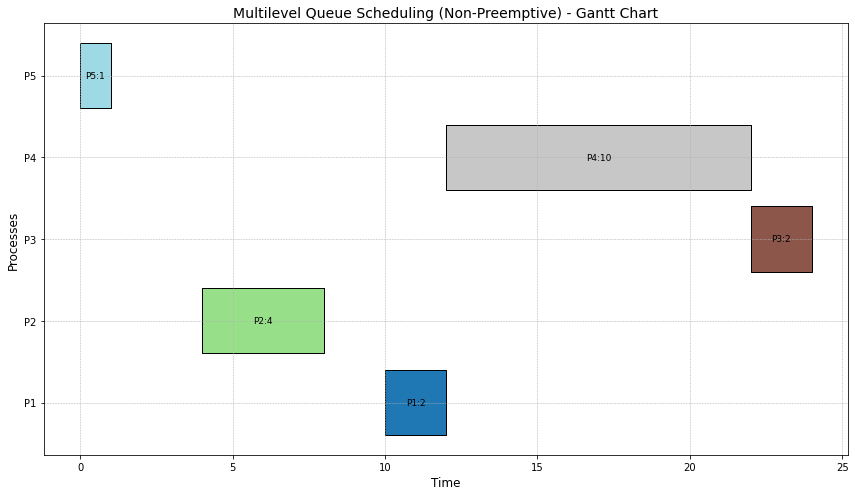

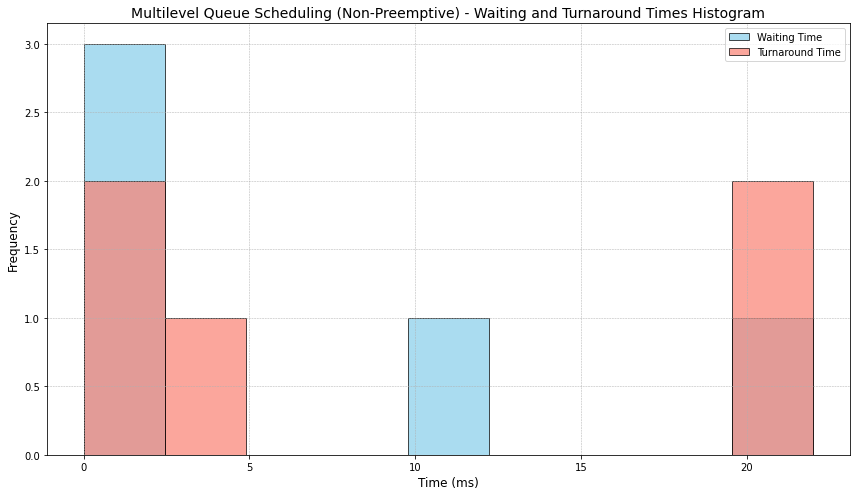

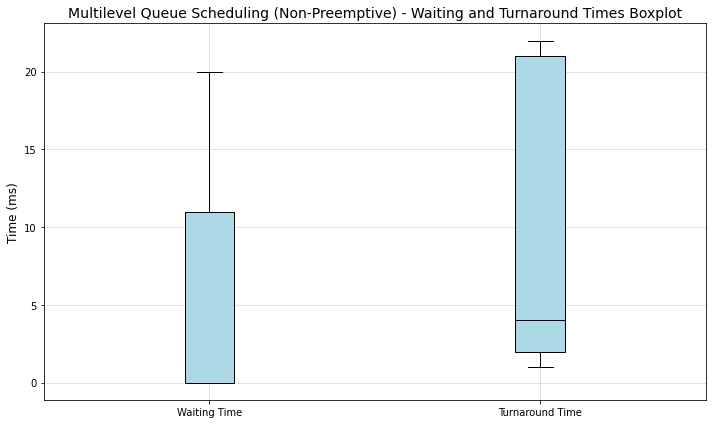

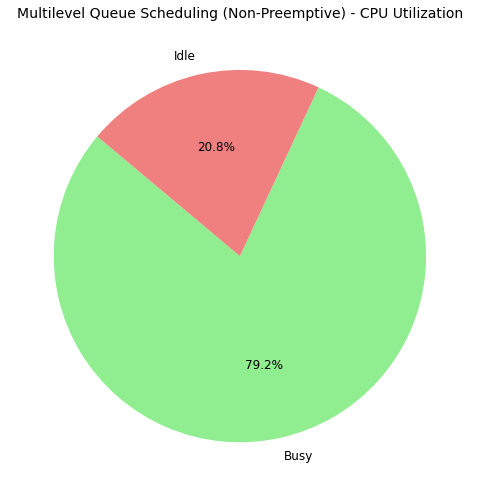

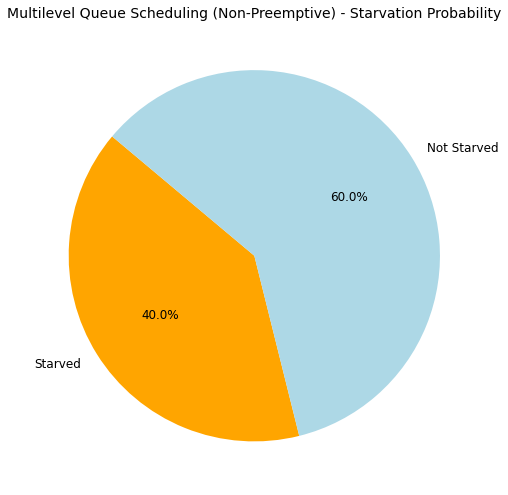


Multilevel Feedback Queue Scheduling - Process Information:

+-----+--------------+------------+----------+--------------+-----------------+-----------------+
| PID | Arrival Time | Burst Time | Priority | Waiting Time | Turnaround Time | Completion Time |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+
|  1  |      10      |     2      |    1     |      11      |       13        |       23        |
|  2  |      4       |     4      |    2     |      8       |       12        |       16        |
|  3  |      2       |     2      |    5     |      14      |       16        |       18        |
|  4  |      1       |     10     |    4     |      0       |        0        |        0        |
|  5  |      0       |     1      |    1     |      22      |       23        |       23        |
+-----+--------------+------------+----------+--------------+-----------------+-----------------+


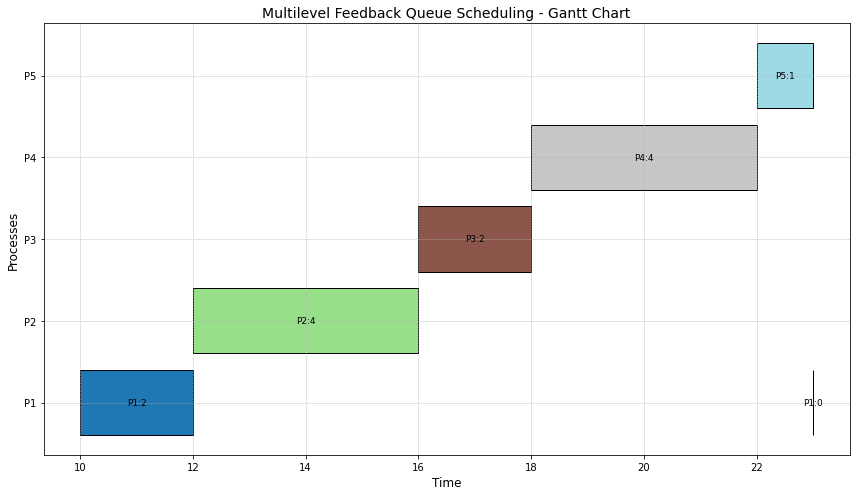

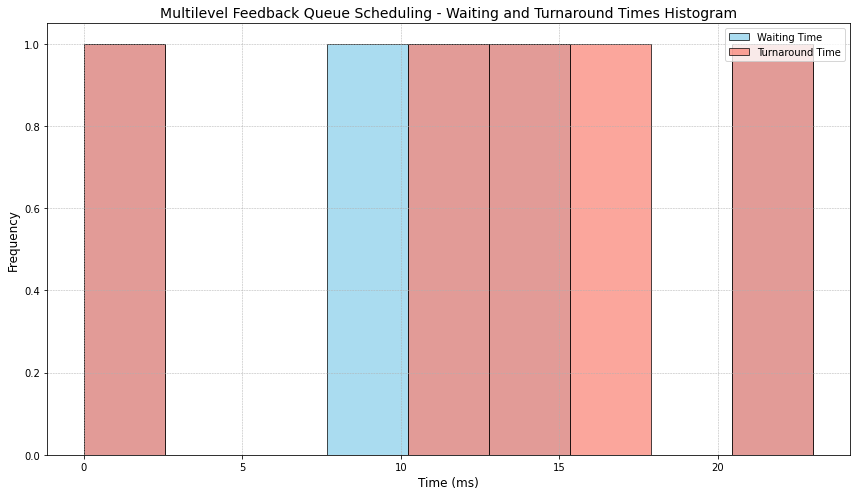

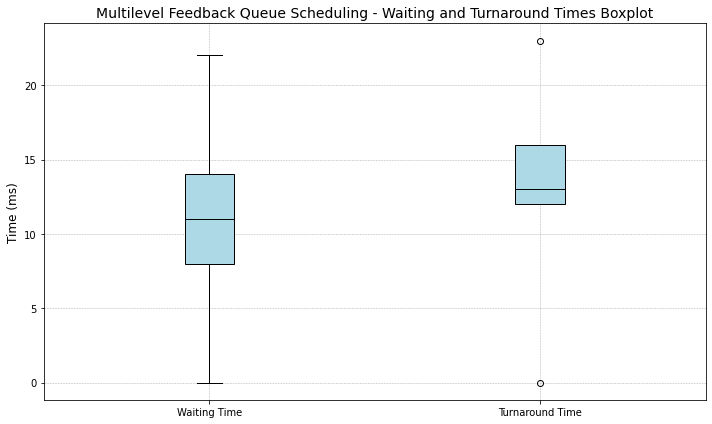

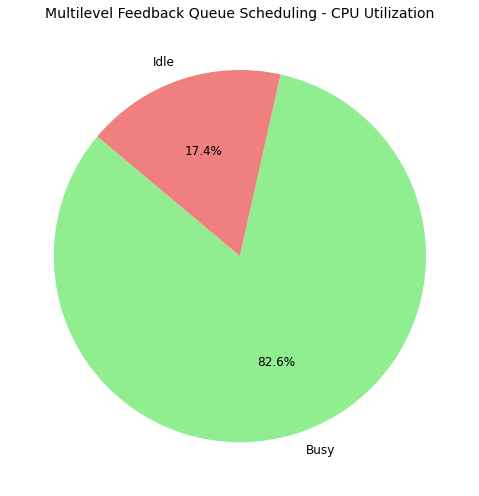

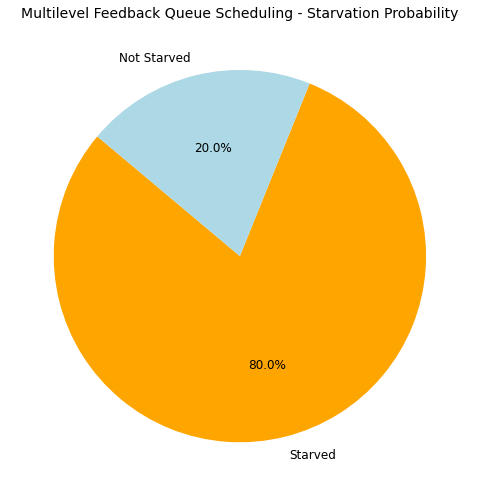

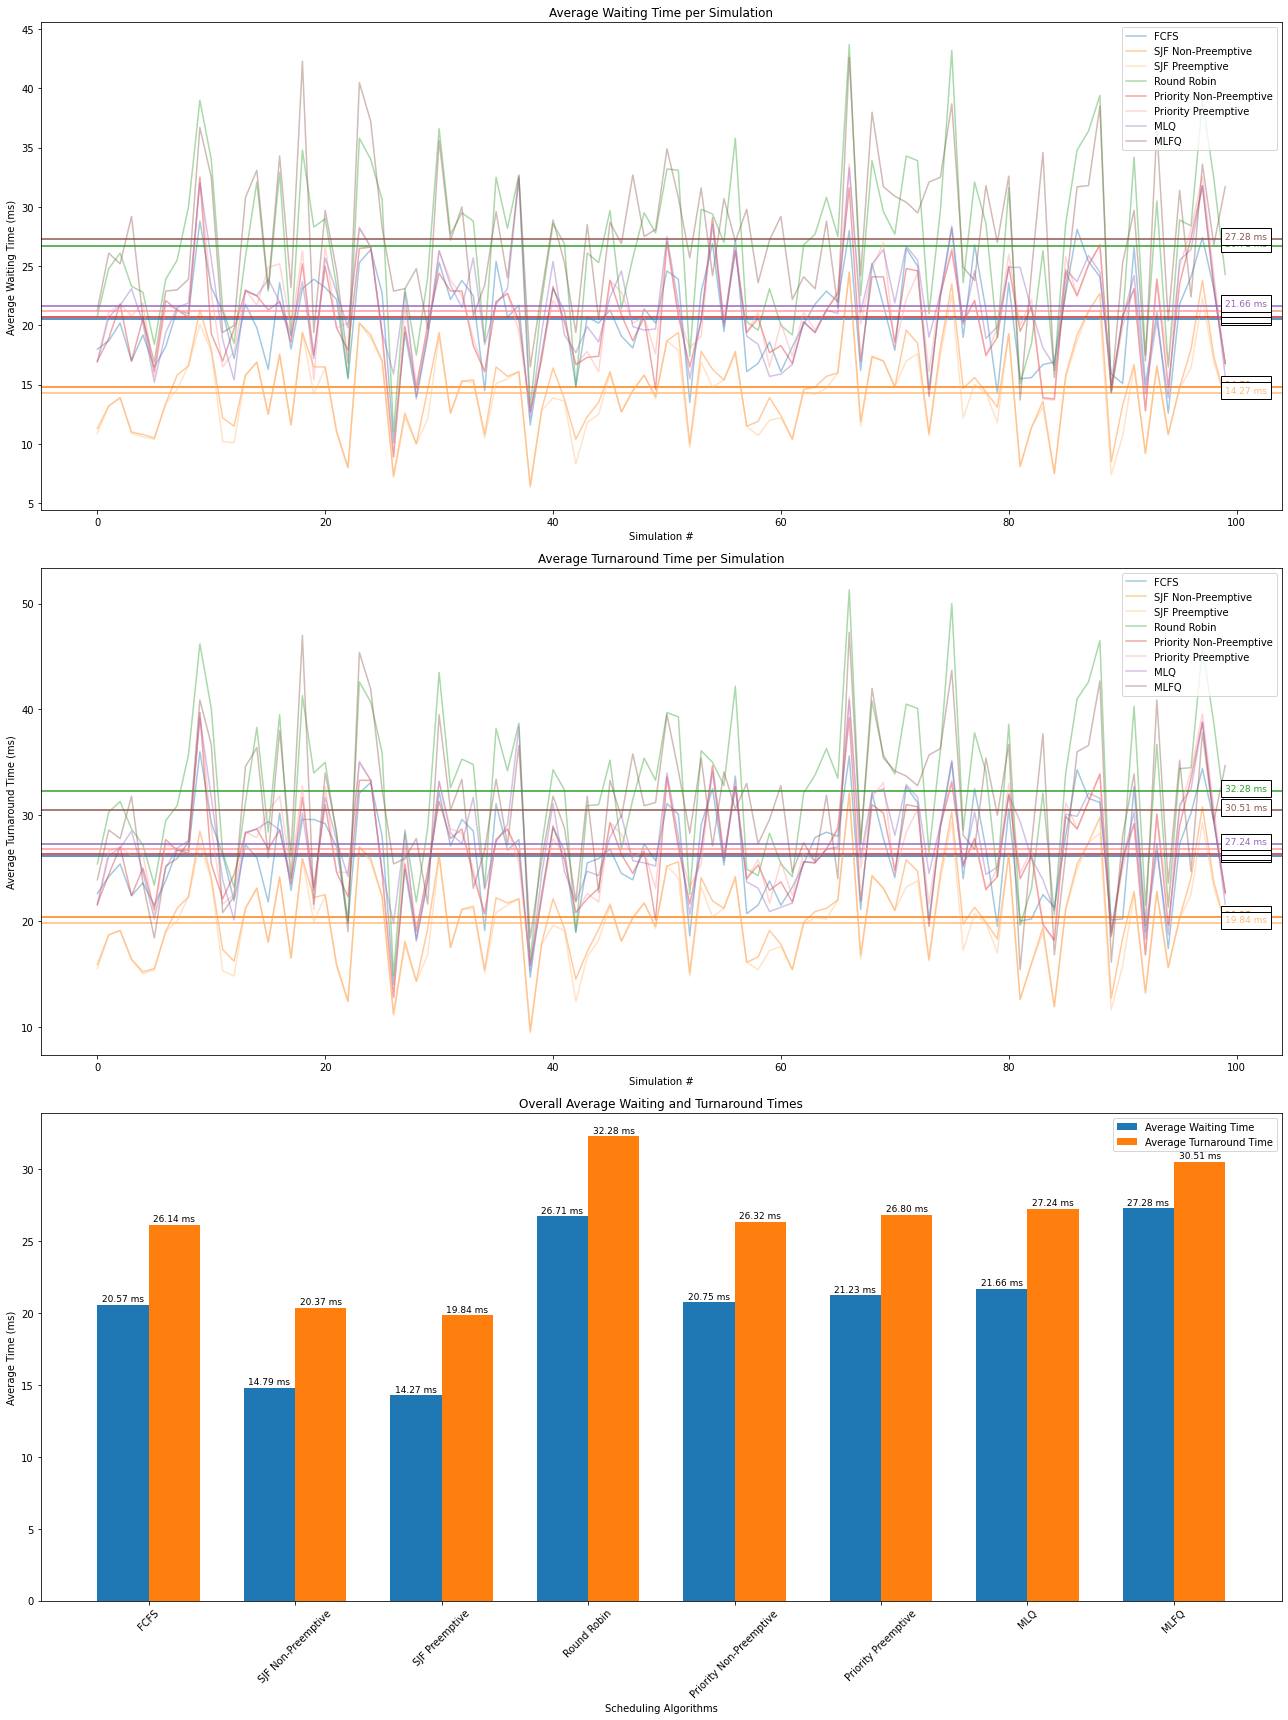


Summary of Average Waiting and Turnaround Times:
+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=========================+=============================+================================+
| FCFS                    |                       20.57 |                          26.14 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Non-Preemptive      |                       14.79 |                          20.37 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Preemptive          |                       14.27 |                          19.84 |
+-------------------------+-----------------------------+--------------------------------+
| Round Robin             |                       26.71 |                          32.28 |
+-------------------------+-------------

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

# Define Process class with tracking for multiple time slices
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time
        self.time_slices = []  # For Gantt chart

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.time_slices.append((current_time, process.burst_time))
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time
        current_time += process.burst_time

# SJF Non-Preemptive Scheduling Function
def sjf_non_preemptive(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    completed = 0
    ready_queue = []
    n = len(processes)
    while completed < n:
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.completion_time == 0):
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            process = current_process
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.burst_time + process.waiting_time
            current_time += process.burst_time
            completed += 1
        else:
            current_time += 1

# SJF Preemptive Scheduling Function (Shortest Remaining Time First)
def sjf_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    ready_queue = []
    n = len(processes)
    last_process = None
    while completed < n:
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.remaining_time > 0):
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.remaining_time)
            current_process = ready_queue[0]
            if last_process != current_process:
                current_process.time_slices.append((current_time, 1))
            else:
                start_time, duration = current_process.time_slices.pop()
                current_process.time_slices.append((start_time, duration + 1))
            current_time += 1
            current_process.remaining_time -= 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                ready_queue.pop(0)
                completed += 1
            last_process = current_process
        else:
            current_time += 1
            last_process = None

# Priority Non-Preemptive Scheduling Function
def priority_non_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    ready_queue = []
    n = len(processes)
    while completed < n:
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.completion_time == 0):
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            process = current_process
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.burst_time + process.waiting_time
            current_time += process.burst_time
            completed += 1
        else:
            current_time += 1

# Priority Preemptive Scheduling Function
def priority_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    ready_queue = []
    n = len(processes)
    last_process = None
    while completed < n:
        for process in processes:
            if (process.arrival_time <= current_time and
                process not in ready_queue and
                process.remaining_time > 0):
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue[0]
            if last_process != current_process:
                current_process.time_slices.append((current_time, 1))
            else:
                start_time, duration = current_process.time_slices.pop()
                current_process.time_slices.append((start_time, duration + 1))
            current_time += 1
            current_process.remaining_time -= 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                ready_queue.pop(0)
                completed += 1
            last_process = current_process
        else:
            current_time += 1
            last_process = None

# Round Robin Scheduling Function
def round_robin_scheduling(processes, time_quantum=4):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    queue = []
    n = len(processes)
    completed = 0
    idx = 0  # Index to track processes that have arrived
    while completed < n:
        while idx < n and processes[idx].arrival_time <= current_time:
            queue.append(processes[idx])
            idx += 1
        if queue:
            process = queue.pop(0)
            if current_time < process.arrival_time:
                current_time = process.arrival_time
            time_slice = min(time_quantum, process.remaining_time)
            process.time_slices.append((current_time, time_slice))
            current_time += time_slice
            process.remaining_time -= time_slice
            if process.remaining_time > 0:
                while idx < n and processes[idx].arrival_time <= current_time:
                    queue.append(processes[idx])
                    idx += 1
                queue.append(process)
            else:
                process.completion_time = current_time
                process.turnaround_time = current_time - process.arrival_time
                process.waiting_time = process.turnaround_time - process.burst_time
                completed += 1
        else:
            if idx < n:
                current_time = processes[idx].arrival_time
            else:
                break

# Multilevel Queue Scheduling Function (Non-Preemptive)
def multilevel_queue_scheduling(processes):
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    current_time = 0
    queues = [high_priority, low_priority]
    for queue in queues:
        # Use FCFS scheduling within each queue
        queue.sort(key=lambda x: x.arrival_time)
        for process in queue:
            if current_time < process.arrival_time:
                current_time = process.arrival_time
            process.time_slices.append((current_time, process.burst_time))
            process.waiting_time = current_time - process.arrival_time
            process.completion_time = current_time + process.burst_time
            process.turnaround_time = process.burst_time + process.waiting_time
            current_time += process.burst_time

# Multilevel Feedback Queue Scheduling Function
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_queues=3):
    queues = [[] for _ in range(num_queues)]
    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)
    current_time = 0
    n = len(processes)
    completed = 0
    idx = 0
    while completed < n:
        # Add arriving processes to the highest priority queue
        while idx < n and processes[idx].arrival_time <= current_time:
            queues[0].append(processes[idx])
            idx += 1
        executed = False
        for i in range(num_queues):
            queue = queues[i]
            if queue:
                process = queue.pop(0)
                if current_time < process.arrival_time:
                    current_time = process.arrival_time
                quantum = time_quantum * (2 ** i)
                time_slice = min(quantum, process.remaining_time)
                process.time_slices.append((current_time, time_slice))
                current_time += time_slice
                process.remaining_time -= time_slice
                if process.remaining_time > 0:
                    if i + 1 < num_queues:
                        queues[i + 1].append(process)
                    else:
                        queues[i].append(process)
                else:
                    process.completion_time = current_time
                    process.turnaround_time = current_time - process.arrival_time
                    process.waiting_time = process.turnaround_time - process.burst_time
                    completed += 1
                executed = True
                break
        if not executed:
            current_time += 1

# Visualization Functions
def gantt_chart(processes, title="Gantt Chart"):
    fig, ax = plt.subplots(figsize=(12, 7))
    cmap = plt.get_cmap('tab20')
    num_processes = len(processes)
    colors = [cmap(i) for i in np.linspace(0, 1, num_processes)]
    for idx, p in enumerate(processes):
        color = colors[idx % len(colors)]
        for (start_time, duration) in p.time_slices:
            ax.broken_barh([(start_time, duration)], (p.pid - 0.4, 0.8),
                           facecolors=(color), edgecolors='black', linewidth=1)
            label = f'P{p.pid}:{duration}'
            ax.text(start_time + duration / 2, p.pid, label, ha='center', va='center',
                    color='black', fontsize=9)
    ax.set_yticks([p.pid for p in processes])
    ax.set_yticklabels([f'P{p.pid}' for p in processes], fontsize=10)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Processes', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def waiting_turnaround_histogram(waiting_times, turnaround_times, title="Waiting and Turnaround Times Histogram"):
    plt.figure(figsize=(12, 7))
    bins = np.linspace(0, max(max(waiting_times), max(turnaround_times)), 10)
    plt.hist(waiting_times, bins=bins, alpha=0.7, label="Waiting Time", color='skyblue', edgecolor='black')
    plt.hist(turnaround_times, bins=bins, alpha=0.7, label="Turnaround Time", color='salmon', edgecolor='black')
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def waiting_turnaround_boxplot(waiting_times, turnaround_times, title="Boxplot of Waiting and Turnaround Times"):
    data = [waiting_times, turnaround_times]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=["Waiting Time", "Turnaround Time"], patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='black'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='black'),
                 capprops=dict(color='black'))
    plt.title(title, fontsize=14)
    plt.ylabel("Time (ms)", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def cpu_utilization(processes, total_time, title="CPU Utilization"):
    busy_time = sum(p.burst_time for p in processes)
    if total_time == 0:
        print(f"Warning: {title} - Total time is zero, unable to calculate CPU Utilization.")
        return
    utilization = (busy_time / total_time) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([utilization, 100 - utilization],
            labels=["Busy", "Idle"],
            autopct='%1.1f%%',
            startangle=140,
            colors=['lightgreen', 'lightcoral'],
            textprops={'fontsize': 12})
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def starvation_probability(processes, threshold=5, title="Starvation Probability"):
    starved = [1 if p.waiting_time > threshold else 0 for p in processes]
    probability = sum(starved) / len(processes) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([probability, 100 - probability],
            labels=["Starved", "Not Starved"],
            autopct='%1.1f%%',
            startangle=140,
            colors=['orange', 'lightblue'],
            textprops={'fontsize':12})
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Main Execution Function for Visualization and Data Display
def visualize_all(processes, scheduling_function, title="Scheduling Algorithm Analysis", **kwargs):
    # Run the scheduling algorithm
    scheduling_function(processes, **kwargs)
    waiting_times = [p.waiting_time for p in processes]
    turnaround_times = [p.turnaround_time for p in processes]
    total_time = max([p.completion_time for p in processes]) if processes else 0

    # Create Table of Process Information
    process_info = []
    for p in processes:
        process_info.append([
            p.pid,
            p.arrival_time,
            p.burst_time,
            p.priority,
            p.waiting_time,
            p.turnaround_time,
            p.completion_time
        ])
    headers = ["PID", "Arrival Time", "Burst Time", "Priority", "Waiting Time", "Turnaround Time", "Completion Time"]
    print(f"\n{title} - Process Information:\n")
    print(tabulate(process_info, headers=headers, tablefmt='pretty'))

    # Gantt Chart
    gantt_chart(processes, title=f"{title} - Gantt Chart")

    # Histogram of Waiting and Turnaround Times
    waiting_turnaround_histogram(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Histogram")

    # Boxplot of Waiting and Turnaround Times
    waiting_turnaround_boxplot(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Boxplot")

    # CPU Utilization
    cpu_utilization(processes, total_time, title=f"{title} - CPU Utilization")

    # Starvation Probability
    starvation_probability(processes, title=f"{title} - Starvation Probability")

# Process generation
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(num_processes)]

# Run simulations with extra versions of algorithms
def run_large_scale_simulation(num_simulations=1000, num_processes=10, time_quantum=4):
    algorithms = [
        ("FCFS", fcfs_scheduling),
        ("SJF Non-Preemptive", sjf_non_preemptive),
        ("SJF Preemptive", sjf_preemptive),
        ("Round Robin", lambda p: round_robin_scheduling(p, time_quantum)),
        ("Priority Non-Preemptive", priority_non_preemptive),
        ("Priority Preemptive", priority_preemptive),
        ("MLQ", lambda p: multilevel_queue_scheduling(p)),
        ("MLFQ", lambda p: multilevel_feedback_queue_scheduling(p, time_quantum))
    ]

    results = {algo: {"waiting_times": np.zeros(num_simulations), "turnaround_times": np.zeros(num_simulations)} for algo, _ in algorithms}

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)
        for algo, func in algorithms:
            cloned_processes = [Process(p.pid, p.arrival_time, p.burst_time, p.priority) for p in processes]
            func(cloned_processes)
            avg_waiting = np.mean([p.waiting_time for p in cloned_processes])
            avg_turnaround = np.mean([p.turnaround_time for p in cloned_processes])
            results[algo]["waiting_times"][i] = avg_waiting
            results[algo]["turnaround_times"][i] = avg_turnaround

    return results

# Visualization with solid averages for all versions
def visualize_large_scale_results_with_solid_averages(results):
    colors = {
        "FCFS": "#1f77b4", "SJF Non-Preemptive": "#ff7f0e", "SJF Preemptive": "#ffbb78",
        "Round Robin": "#2ca02c", "Priority Non-Preemptive": "#d62728", "Priority Preemptive": "#ff9896",
        "MLQ": "#9467bd", "MLFQ": "#8c564b"
    }

    overall_averages = {algo: [np.mean(data["waiting_times"]), np.mean(data["turnaround_times"])] for algo, data in results.items()}

    # Plot Waiting Times
    plt.figure(figsize=(18, 24))
    plt.subplot(3, 1, 1)
    for algo, data in results.items():
        plt.plot(data["waiting_times"], label=algo, color=colors[algo], alpha=0.4)
        plt.axhline(y=overall_averages[algo][0], color=colors[algo], linestyle="-")
        plt.text(len(data["waiting_times"]) - 1, overall_averages[algo][0],
                 f"{overall_averages[algo][0]:.2f} ms", color=colors[algo], ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time (ms)")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Plot Turnaround Times
    plt.subplot(3, 1, 2)
    for algo, data in results.items():
        plt.plot(data["turnaround_times"], label=algo, color=colors[algo], alpha=0.4)
        plt.axhline(y=overall_averages[algo][1], color=colors[algo], linestyle="-")
        plt.text(len(data["turnaround_times"]) - 1, overall_averages[algo][1],
                 f"{overall_averages[algo][1]:.2f} ms", color=colors[algo], ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time (ms)")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()

    # Bar chart for overall averages
    plt.subplot(3, 1, 3)
    labels = list(overall_averages.keys())
    waiting_times = [overall_averages[algo][0] for algo in labels]
    turnaround_times = [overall_averages[algo][1] for algo in labels]
    bar_width = 0.35
    index = np.arange(len(labels))
    plt.bar(index, waiting_times, bar_width, label="Average Waiting Time")
    plt.bar(index + bar_width, turnaround_times, bar_width, label="Average Turnaround Time")
    plt.xlabel("Scheduling Algorithms")
    plt.ylabel("Average Time (ms)")
    plt.title("Overall Average Waiting and Turnaround Times")
    plt.xticks(index + bar_width / 2, labels, rotation=45)

    for i, v in enumerate(waiting_times):
        plt.text(i, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(turnaround_times):
        plt.text(i + bar_width, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display summary table
    summary_data = {
        "Algorithm": labels,
        "Average Waiting Time (ms)": [round(value, 2) for value in waiting_times],
        "Average Turnaround Time (ms)": [round(value, 2) for value in turnaround_times]
    }
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary of Average Waiting and Turnaround Times:")
    print(summary_df.to_markdown(index=False, tablefmt="grid"))

# Example usage with different scheduling algorithms
if __name__ == "__main__":
    # Generate random processes for testing
    random.seed(42)  # Set seed for reproducibility
    processes = [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(5)]

    # Test FCFS Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  fcfs_scheduling, title="FCFS Scheduling")

    # Test SJF Non-Preemptive Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  sjf_non_preemptive, title="SJF Non-Preemptive Scheduling")

    # Test SJF Preemptive Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  sjf_preemptive, title="SJF Preemptive Scheduling")

    # Test Round Robin Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  round_robin_scheduling, title="Round Robin Scheduling", time_quantum=4)

    # Test Priority Non-Preemptive Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  priority_non_preemptive, title="Priority Non-Preemptive Scheduling")

    # Test Priority Preemptive Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  priority_preemptive, title="Priority Preemptive Scheduling")

    # Test Multilevel Queue Scheduling (Non-Preemptive)
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  multilevel_queue_scheduling, title="Multilevel Queue Scheduling (Non-Preemptive)")

    # Test Multilevel Feedback Queue Scheduling
    visualize_all([Process(pid=p.pid,
                           arrival_time=p.arrival_time,
                           burst_time=p.burst_time,
                           priority=p.priority) for p in processes],
                  multilevel_feedback_queue_scheduling, title="Multilevel Feedback Queue Scheduling",
                  time_quantum=4, num_queues=3)

    # Run large-scale simulation
    results = run_large_scale_simulation(num_simulations=100, num_processes=10, time_quantum=4)
    visualize_large_scale_results_with_solid_averages(results)


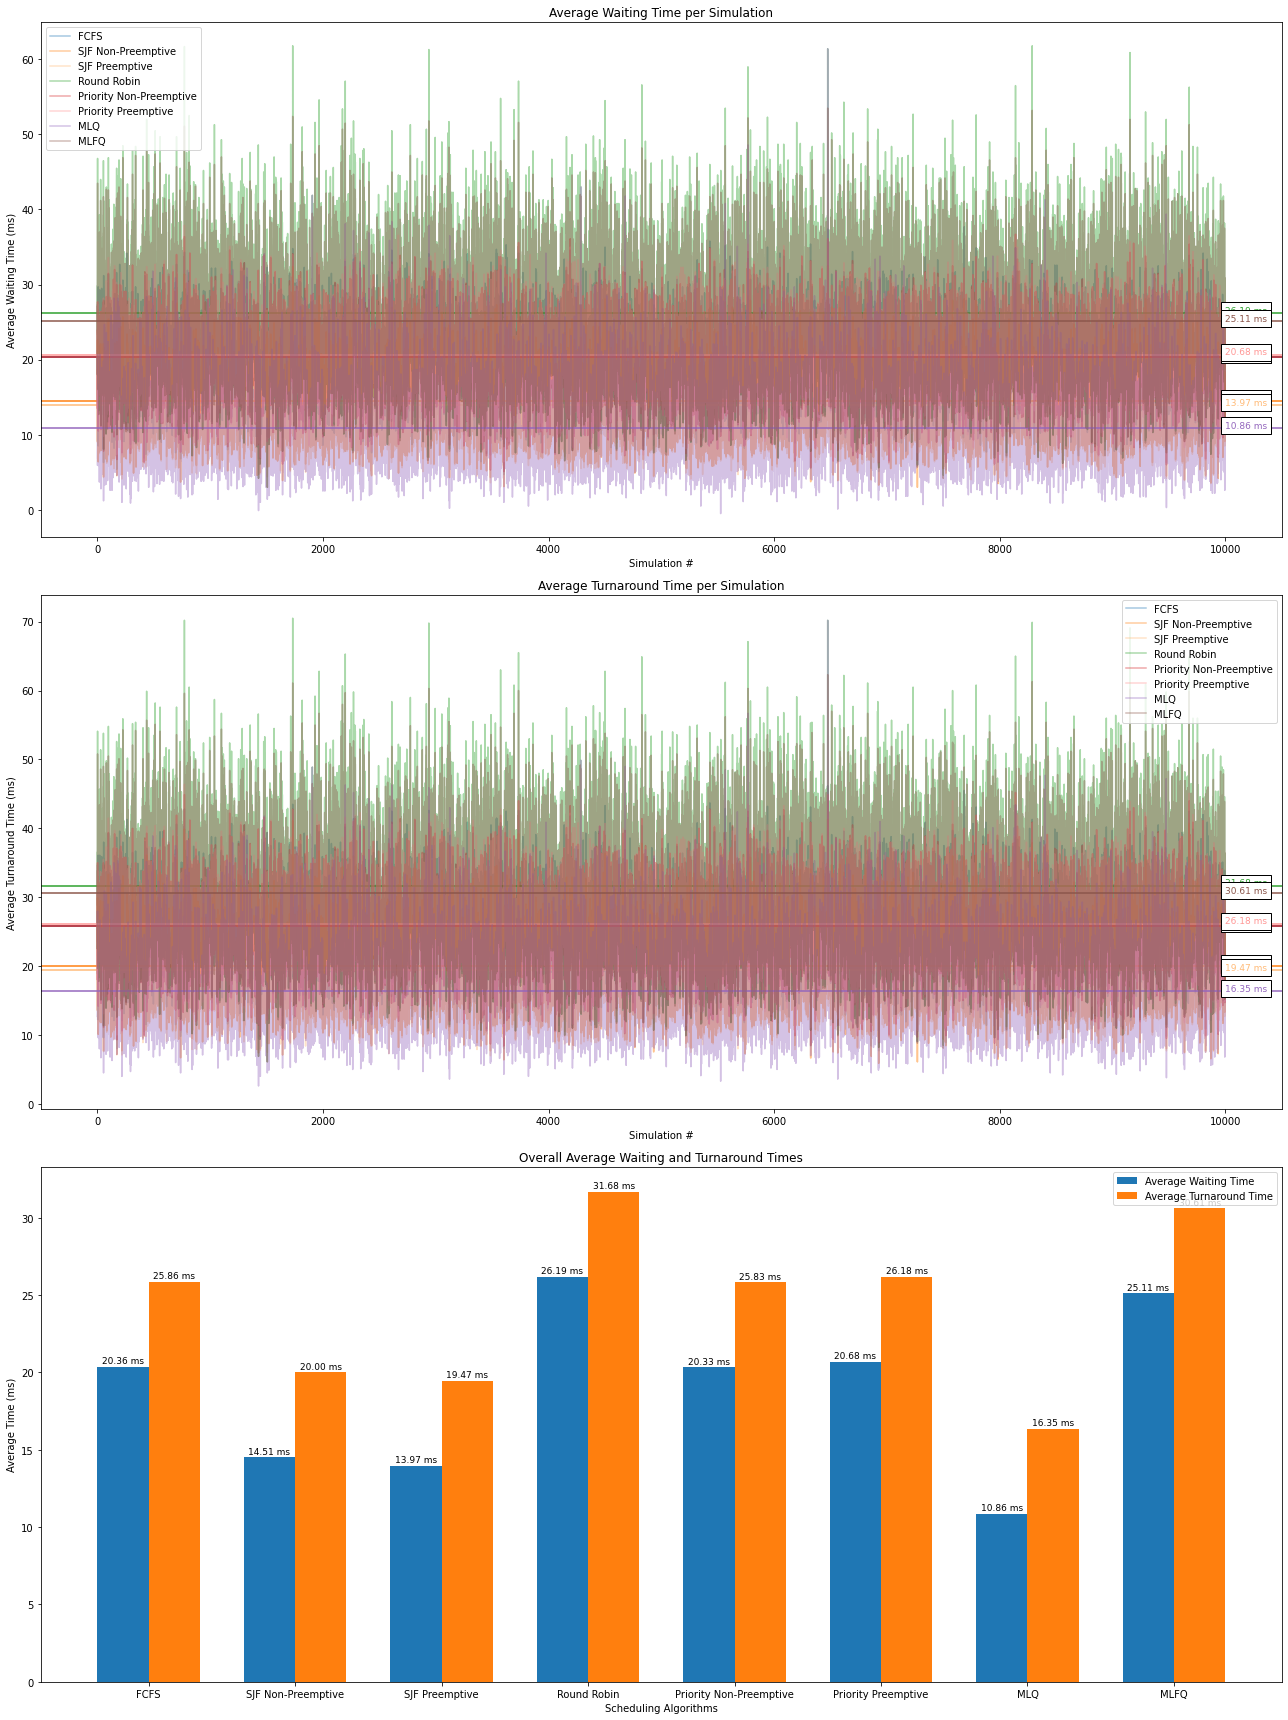


Summary of Average Waiting and Turnaround Times:
+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=========================+=============================+================================+
| FCFS                    |                       20.36 |                          25.86 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Non-Preemptive      |                       14.51 |                          20    |
+-------------------------+-----------------------------+--------------------------------+
| SJF Preemptive          |                       13.97 |                          19.47 |
+-------------------------+-----------------------------+--------------------------------+
| Round Robin             |                       26.19 |                          31.68 |
+-------------------------+-------------

In [49]:
# 10 Processes

# Main execution to run simulations and visualize
if __name__ == "__main__":
    results = run_large_scale_simulation(num_simulations=10000, num_processes=10)
    visualize_large_scale_results_with_solid_averages(results)

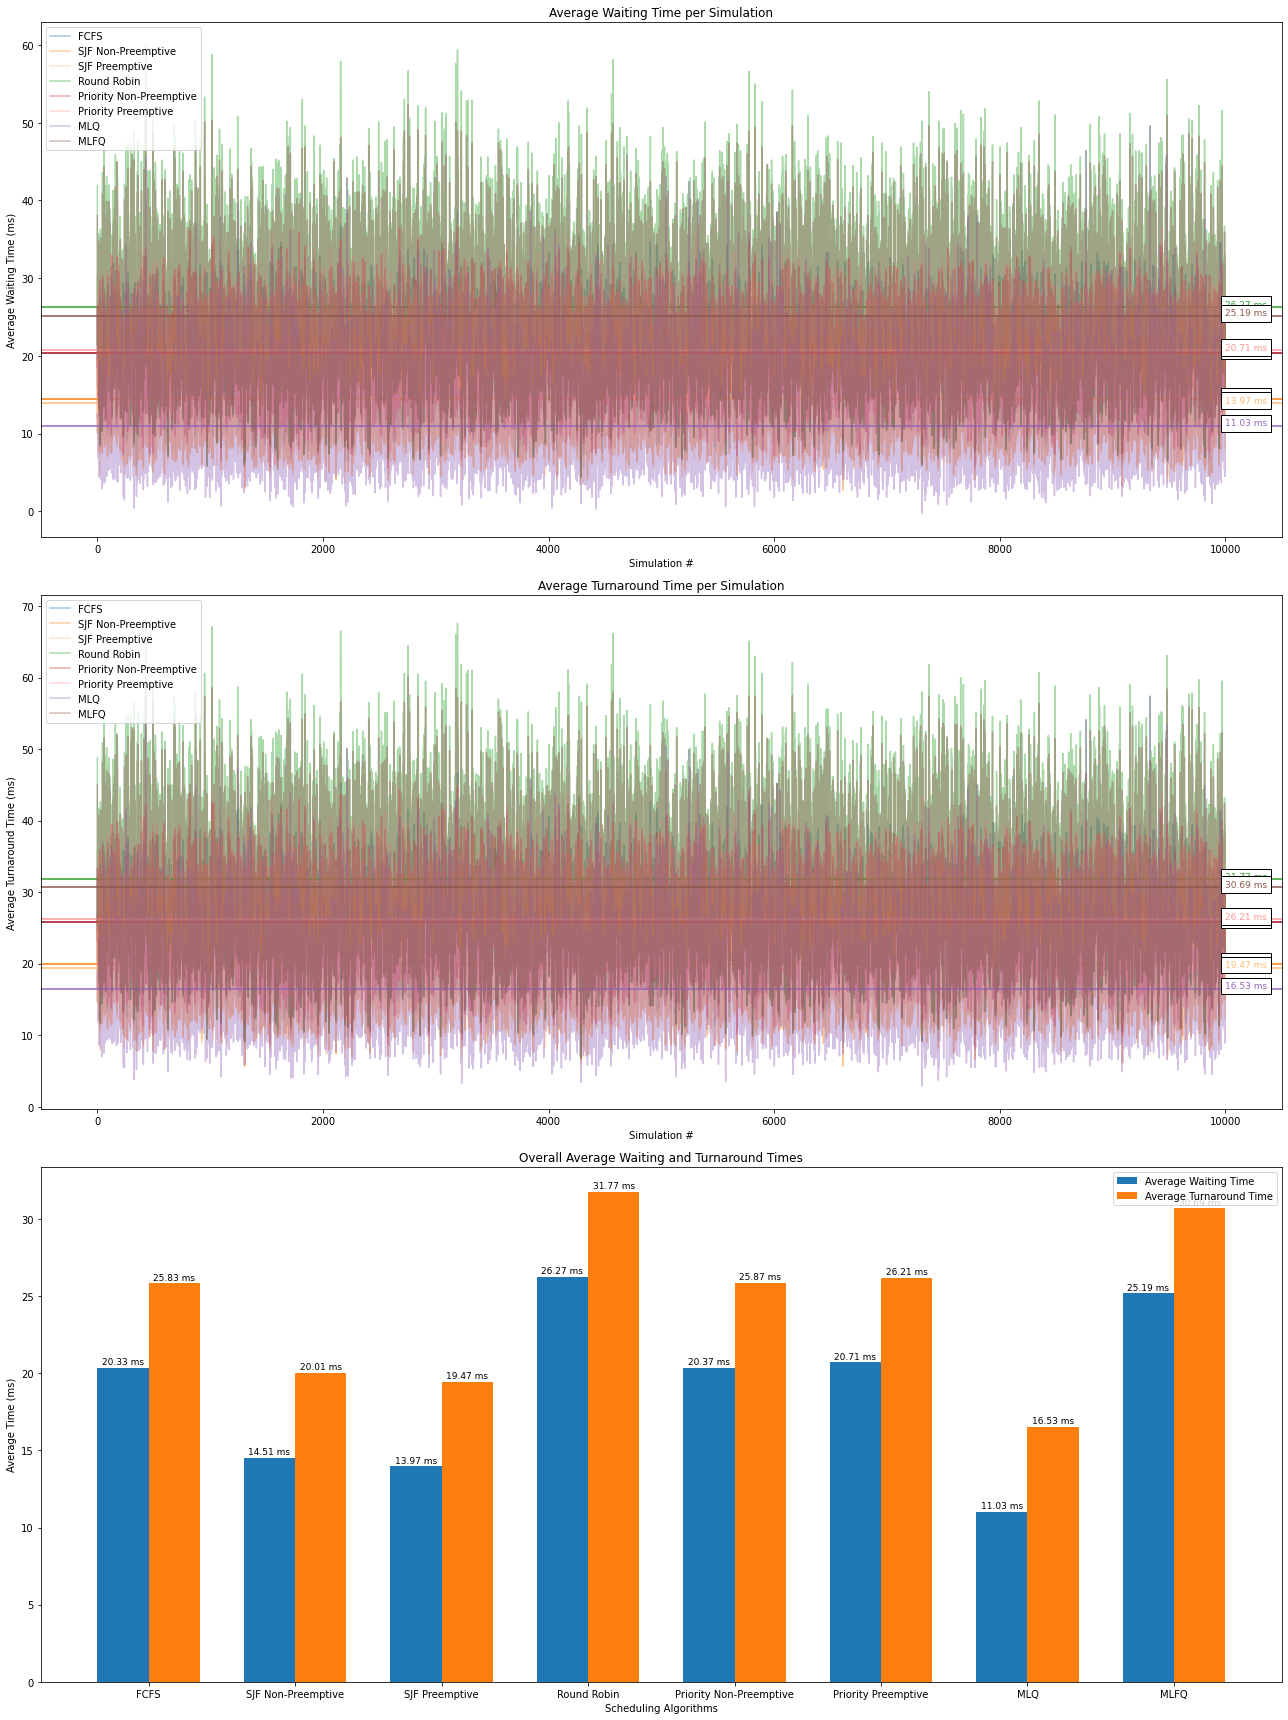


Summary of Average Waiting and Turnaround Times:
+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=========================+=============================+================================+
| FCFS                    |                       20.33 |                          25.83 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Non-Preemptive      |                       14.51 |                          20.01 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Preemptive          |                       13.97 |                          19.47 |
+-------------------------+-----------------------------+--------------------------------+
| Round Robin             |                       26.27 |                          31.77 |
+-------------------------+-------------

In [ ]:
# 100 Processes

# Main execution to run simulations and visualize
if __name__ == "__main__":
    results = run_large_scale_simulation(num_simulations=10000, num_processes=100)
    visualize_large_scale_results_with_solid_averages(results)